# Progetto ML
### Predizione del livello di progressione della malattia a un anno di distanza, utilizzando 10 variabili misurate sui pazienti.

Nel contesto del progetto di machine learning è stato addestrato un modello di classificazione per stimare il livello di progressione della malattia a un anno di distanza, utilizzando dieci variabili raccolte dai pazienti.

In fase preliminare, è stata realizzata un'analisi esplorativa dei dati per acquisire una comprensione delle caratteristiche del dataset. Sono state analizzate le distribuzioni delle variabili e le relazioni tra di esse, al fine di individuare pattern e tendenze utili per la modellazione.

Per garantire un confronto accurato, è stato inizialmente utilizzato un baseline model, che ha servito come riferimento per valutare le prestazioni dei modelli successivi.
Il modello scelto per la classificazione è stato **Ridge** per il quale sono stati valutati i parametri per una sua ottimizzazione.

## Indice  
1. Importazione delle librerie necessarie
2. Caricamento del dataset e suddivisione features e labels
3. Esplorazione preliminare del dataset Diabetes
   - Il dataset  
   - Le etichette
   - Le features  
4. Baseline model  
5. Ottimizzazione del modello  
   5.1 Rimozione possibili outliers  
   5.2 Selezione delle features  
6. Modelli per ridurre la multicollinearità  
   - Lasso e Ridge   
7. Costruzione del modello e performance

## 1. Importazione delle librerie necessarie

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn import datasets
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_validate, KFold

## 2. Caricamento del dataset e suddivisione features e labels

In [2]:
df = datasets.load_diabetes()

In [3]:
# Con questo passaggio inserisco all'interno di 'X' i valori delle features e in 'y' le labels
X = df['data']
feature_names = df['feature_names']
# Creo un DataFrame e assegno i nomi delle colonne
X = pd.DataFrame(X, columns=feature_names)

y = df['target']
# Creo un DataFrame e assegno i nomi delle colonne
y = pd.DataFrame(y, columns=['label'])

In [4]:
print(X.shape, y.shape)

(442, 10) (442, 1)


## 3. Esplorazione del dataset Diabetes

<span style="color: red; font-size: 18px; font-weight: bold;">
Il Dataset
</span>

In [5]:
print(df['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

<span style="color: red; font-size: 18px; font-weight: bold;">
Le etichette
</span>

In [6]:
# Le labels da che tipo di dato sono rappresentate?
print(y.dtypes)

label    float64
dtype: object


In [7]:
y.describe()

,label
count,442.000000
mean,152.133484
std,77.093005
min,25.000000
25%,87.000000
50%,140.500000
75%,211.500000
max,346.000000


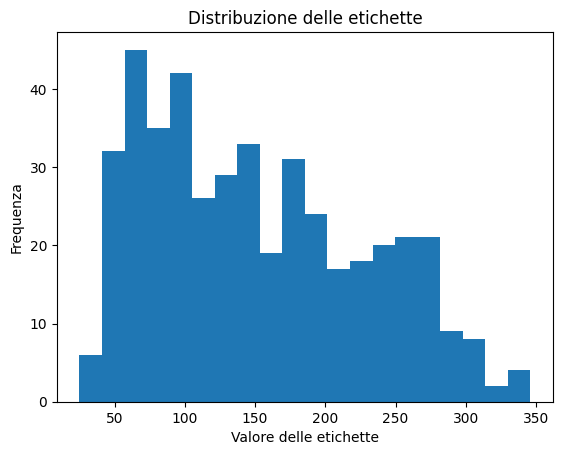

In [8]:
# Come si distribuiscono i valori delle labels?
plt.hist(y, bins=20)
plt.title("Distribuzione delle etichette")
plt.xlabel("Valore delle etichette")
plt.ylabel("Frequenza")
plt.show()

**Da una prima analisi delle etichette emerge:**

1. **Tipo di dato delle etichette:**
   Le etichette sono espresse come numeri in formato `float64`, il che indica che si tratta di valori continui, posizionando il problema nel campo della **regressione**.

2. **Distribuzione delle etichette:**
   Dall'istogramma emerge che le etichette non seguono una distribuzione uniforme. È evidente una concentrazione più elevata di valori nell'intervallo compreso tra 50 e 150, suggerendo una distribuzione non omogenea.

---

**Modello da considerare:**

Poiché le etichette sono valori continui, è necessario un modello di **regressione**. Tra le possibili opzioni:

- **Regressione lineare**: se la relazione tra le variabili e le etichette è lineare.
- **Regressione lineare con regolarizzazione**:
  - **Lasso**
  - **Ridge**
- **Modelli non lineari**: come la regressione polinomiale o algoritmi basati su alberi decisionali, ad esempio:
  - **Random Forest Regressor**

---

**Considerazioni:**

È importante verificare:
- La **correlazione** tra le variabili indipendenti e le etichette.

<span style="color: red; font-size: 18px; font-weight: bold;">
Le features
</span>

In [9]:
# Quali features sono presenti?
X.columns

Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'], dtype='object')

In [10]:
# Ciascuna delle feature da che tipo di dato è rappresentata?
print(X.dtypes)

age    float64
sex    float64
bmi    float64
bp     float64
s1     float64
s2     float64
s3     float64
s4     float64
s5     float64
s6     float64
dtype: object


In [11]:
# Sono presenti dati mancanti?
X.isnull().any()

,0
age,False
sex,False
bmi,False
bp,False
s1,False
s2,False
s3,False
s4,False
s5,False
s6,False


In [12]:
# Esplorazione preliminare dei valori
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


In [13]:
# Come si distribuiscono i valori delle features?

# Creo la figura con 4 righe e 3 colonne
fig = make_subplots(
    rows=4, cols=3,
    subplot_titles=X.columns,
    shared_yaxes=False
)

# Aggiungo un istogramma per ogni colonna
for i, feature in enumerate(X.columns):
    # Calcolo la posizione di riga e colonna nella griglia
    row = i // 3 + 1  # Righe (ogni 3 grafici si va a capo)
    col = i % 3 + 1  # Colonne (si riparte a 1 dopo ogni 3)

    # Creo l'istogramma per la feature
    fig.add_trace(
        go.Histogram(x=X[feature], nbinsx=30, histnorm='density', opacity=0.6),
        row=row, col=col
    )

    # Aggiungo i titoli agli assi dell'istogramma
    fig.update_xaxes(title_text="Valore", row=row, col=col)
    fig.update_yaxes(title_text="Frequenza", row=row, col=col)

# Miglioramenti alla leggibilità
fig.update_layout(
    showlegend=False,
    width=1000,  # Larghezza della figura
    height=1000, # Altezza della figura
    title="Distribuzione delle Features"
)

# Mostra il grafico
fig.show()

Le feature hanno una distribuzione con media 0 e varianza uniforme, come riportato anche nella descrizione del dataset. Questo le rende pronte per l’uso nei modelli sensibili alla scala (come regressioni lineari, SVM o reti neurali). **Non è necessaria ulteriore standardizzazione o normalizzazione**. La magnitudine complessiva di ogni feature è bilanciata rispetto al dataset e che nessuna feature domina in termini di scala.

**Vantaggi**  
• Modelli lineari: Tecniche come la regressione lineare, SVM lineare o logistic regression beneficiano molto da questo tipo di preprocessamento, in quanto evita problemi dovuti a scale diverse tra le feature.  
• Regolarizzazione: Per tecniche come Lasso e Ridge la scalatura uniforme garantisce che il processo di penalizzazione sia equo tra le feature.

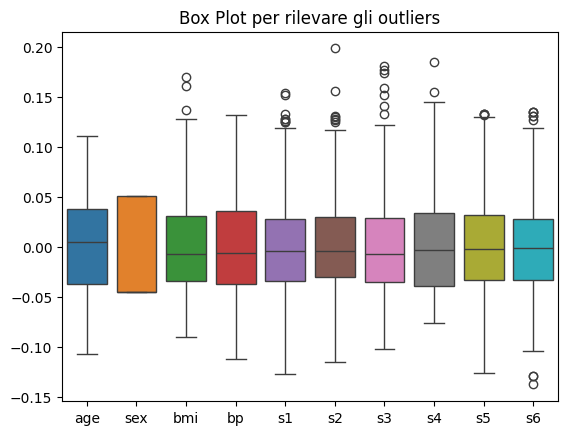

In [14]:
# Sono presenti outliers?

# Box plot
sns.boxplot(data=X)
plt.title('Box Plot per rilevare gli outliers')
plt.show()

In [15]:
# Individuo gli outliers

# Inizializzo un set vuoto per memorizzare tutti gli outliers senza duplicati
all_outliers_indices = set()

# Calcolo Q1 (25° percentile), Q3 (75° percentile) e l'IQR
for column in X.columns:
    Q1 = X[column].quantile(0.25)
    Q3 = X[column].quantile(0.75)
    IQR = Q3 - Q1

    # Identificoe gli outliers
    outliers_lower = X[X[column] < (Q1 - 1.5 * IQR)]
    outliers_upper = X[X[column] > (Q3 + 1.5 * IQR)]

    # Verifico se ci sono outliers inferiori
    if not outliers_lower.empty:
        print(f" {outliers_lower.shape[0]} Outliers inferiori per la feature {column}:{outliers_lower.index.values}")
        # Aggiungo gli indici degli outliers inferiori al set
        all_outliers_indices.update(outliers_lower.index.values)
    else:
        print(f"Nessun outlier inferiore per la feature {column}")

    # Verifico se ci sono outliers superiori
    if not outliers_upper.empty:
        print(f" {outliers_upper.shape[0]} Outliers superiori per la feature {column}: {outliers_upper.index.values}")
        # Aggiungo gli indici degli outliers superiori al set
        all_outliers_indices.update(outliers_upper.index.values)
    else:
        print(f"Nessun outlier superiore per la feature {column}")
    print("\n")
print(all_outliers_indices)

Nessun outlier inferiore per la feature age
Nessun outlier superiore per la feature age


Nessun outlier inferiore per la feature sex
Nessun outlier superiore per la feature sex


Nessun outlier inferiore per la feature bmi
 3 Outliers superiori per la feature bmi: [256 366 367]


Nessun outlier inferiore per la feature bp
Nessun outlier superiore per la feature bp


Nessun outlier inferiore per la feature s1
 8 Outliers superiori per la feature s1: [123 161 202 230 248 276 287 346]


Nessun outlier inferiore per la feature s2
 7 Outliers superiori per la feature s2: [123 161 230 248 287 346 376]


Nessun outlier inferiore per la feature s3
 7 Outliers superiori per la feature s3: [ 35  58 260 261 269 286 441]


Nessun outlier inferiore per la feature s4
 2 Outliers superiori per la feature s4: [123 322]


Nessun outlier inferiore per la feature s5
 4 Outliers superiori per la feature s5: [ 23 169 322 353]


 3 Outliers inferiori per la feature s6:[ 84 245 406]
 6 Outliers superiori pe

In [16]:
# Sono presenti correlazioni lineari tra le features e la label?

# Creo il subplot
fig = make_subplots(
    rows=4, cols=3,
    subplot_titles=X.columns,
    shared_yaxes=False
)

# Itero sulle colonne di X (le features) e creo uno scatter plot
for i, feature in enumerate(X.columns):
    row = i // 3 + 1  # Rileva la riga
    col = i % 3 + 1   # Rileva la colonna

    # Aggiungo un trace (scatter plot) per ogni feature
    fig.add_trace(
        go.Scatter(
            x=X[feature],
            y=y.squeeze(),  # .squeeze() per convertire la serie y in array 1D
            mode='markers',
            name=feature
        ),
        row=row, col=col
    )

# Aggiorno il layout
fig.update_layout(
    height=1200,
    width=800,
    title_text="Feature vs Label Scatter Plots",
    showlegend=False
)

# Mostra il grafico
fig.show()

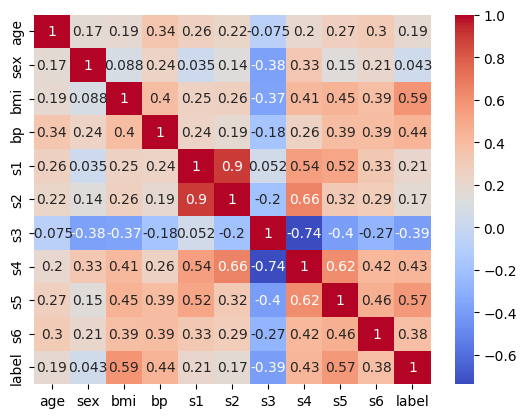

In [17]:
#Visualizzo la correlazione con una matrice di correlazione

# Aggiungo y come una colonna di X per calcolare la matrice di correlazione
df_tot = X.copy()
df_tot['label'] = y

# Calcolare la matrice di correlazione
corr_matrix = df_tot.corr()

# Visualizzare la matrice di correlazione con una heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [18]:
corr_matrix["label"].sort_values(ascending=False)

,label
label,1.000000
bmi,0.586450
s5,0.565883
bp,0.441482
s4,0.430453
s6,0.382483
s1,0.212022
age,0.187889
s2,0.174054
sex,0.043062


##### Osservando la matrice di correlazione:

**Feature con correlazione alta tra loro**:  
*Correlazione positiva*:  
• s1 e s2: Correlazione positiva molto forte  
• s2 e s4: Correlazione positiva forte  
• s5 e s4: Correlazione positiva forte  
• s1 e s4: Correlazione positiva moderatamente forte   
• s1 e s5: Correlazione positiva moderatamente forte

*Correlazione negativa*:  
• s3 e s4: Correlazione negativa molto forte

**Feature correlate con la variabile target (label**):  
• s5 e bmi  mostrano una correlazione positiva più evidente rispetto alle altre feature con la variabile target, quindi sembrano particolarmente utili per il modello.  
• bp, s3, s4 e s6 hanno una correlazione più moderata, ma potrebbero comunque essere rilevanti.  
• age, sex, s1, s2 mostrano correlazioni più deboli e quasi assenti con la variabile target e potrebbero essere meno importanti.  
  
Quando le feature sono linearmente correlate, si verifica la *multicollinearità*, che può portare a:  
• Instabilità nei coefficienti del modello, rendendo difficile interpretare i risultati.  
• Ridotta interpretabilità, poiché è complicato capire l'influenza individuale di ciascuna variabile.  
• Overfitting, poiché il modello può adattarsi troppo ai dati di allenamento e non generalizzare bene.

## 4. Baseline model

Considerando le correlazioni moderate di alcune feature con la label, una regressione lineare potrebbe essere un buon punto di partenza come baseline. La regressione lineare, infatti, è un modello semplice da interpretare e fornisce un punto di partenza utile per confrontare le prestazioni dei modelli più complessi che verranno successivamente applicati. Questo approccio consente di stabilire una base di performance su cui poter misurare eventuali miglioramenti nei modelli successivi.

In [19]:
#Divido i dati in test set, val set e training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Divido il training set in training e validation set (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Creo il modello di regressione lineare
model = LinearRegression()

# Alleno il modello sui dati di training
model.fit(X_train, y_train)

# Faccio delle predizioni sui dati di val
y_pred = model.predict(X_val)

# Faccio delle predizioni sui dati di training
y_pred_train = model.predict(X_train)

# Calcolo gli errori e R² per i dati di val
mse_blm = mean_squared_error(y_val, y_pred)
mae_blm = mean_absolute_error(y_val, y_pred)
r2_blm = r2_score(y_val, y_pred)

# Calcolo gli errori e R² per i dati di addestramento
mse_train = mean_squared_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

# Stampo i risultati per val e training
print(f'\n-- Risultati sui dati di addestramento --')
print(f'Mean Absolute Error (MAE) - Train: {mae_train}')
print(f'Mean Squared Error (MSE) - Train: {mse_train}')
print(f'R^2 Score - Train: {r2_train}\n')

print(f'-- Risultati sui dati di validazione --')
print(f'Mean Absolute Error (MAE) - Val: {mae_blm}')
print(f'Mean Squared Error (MSE) - Val: {mse_blm}')
print(f'R^2 Score - Val: {r2_blm}')


-- Risultati sui dati di addestramento --
Mean Absolute Error (MAE) - Train: 43.297615418575
Mean Squared Error (MSE) - Train: 2872.102536938399
R^2 Score - Train: 0.521812270302883

-- Risultati sui dati di validazione --
Mean Absolute Error (MAE) - Val: 47.660311472856954
Mean Squared Error (MSE) - Val: 3280.9353227550164
R^2 Score - Val: 0.45277585593380554


Non c'è un forte overfitting. La leggera differenza tra le metriche di errore e R² sui dati di addestramento e di test indica che il modello sta generalizzando abbastanza bene, ma c'è ancora margine di miglioramento.
Il modello sembra moderatamente bilanciato, con performance simili su entrambi i set (train e val), ma con spazio per migliorare, specialmente se riuscissimo a migliorare la qualità dei dati o a fare un tuning più accurato del modello.

**Metriche usate per la valutazione:**  
	1.	**Mean Absolute Error (MAE):**  
	•	*Definizione:* Media dei valori assoluti delle differenze tra le predizioni e i valori reali.  
	•	*Interpretazione:* Indica l’errore medio assoluto, intuitivo per capire quanto in media le predizioni si discostano dai valori reali.  
	2.	**Mean Squared Error (MSE):**  
	•	*Definizione:* Media dei quadrati degli errori (differenze tra predizioni e valori reali).  
	•	*Interpretazione:* Penalizza maggiormente gli errori più grandi rispetto a MAE. È utile se si vuole che il modello dia più importanza alla riduzione di grandi errori.    
	3.	**R² Score (coefficiente di determinazione):**  
	•	*Definizione:* Una misura della proporzione di varianza spiegata dal modello rispetto alla varianza totale.  
	•	*Interpretazione:* Un valore vicino a 1 indica che il modello spiega bene la variabilità dei dati. Valori negativi indicano un modello peggiore di una semplice media.   

## 5. Ottimizzazione del Baseline Model

Prima di scegliere un altro modello, si intende valutare se alcuni accorgimenti applicati al train set possano migliorare le performance del modello di Regressione Lineare, mantenendo lo stesso modello della baseline. L'obiettivo è analizzare l'impatto delle caratteristiche del train set sulle performance del modello, esaminando come le modifiche ai dati di input possano influenzare l'accuratezza e l'affidabilità delle previsioni.

<span style="color: red; font-size: 18px; font-weight: bold;">
    Rimozione possibili outliers
</span>

In generale, è consigliabile rimuovere gli outliers solo dal training set per evitare che distorcano l'apprendimento del modello. Gli outliers nel training set possono influenzare negativamente le performance del modello, impedendo una generalizzazione corretta. Rimuovendoli solo dal training set, il modello impara senza essere influenzato da questi valori estremi.

Nel test set, invece, gli outliers devono essere mantenuti per garantire che il set di test rimanga rappresentativo della distribuzione dei dati reali, consentendo una valutazione accurata del modello, anche in presenza di anomalie.

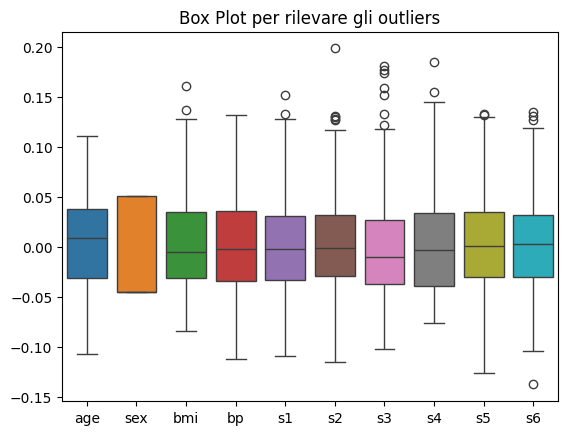

In [21]:
# Box plot
sns.boxplot(data=X_train)
plt.title('Box Plot per rilevare gli outliers')
plt.show()

In [22]:
# Inizializzo un set vuoto per memorizzare tutti gli outliers senza duplicati
all_outliers_indices = set()

# Calcolo Q1 (25° percentile), Q3 (75° percentile) e l'IQR
for column in X_train.columns:
    Q1 = X_train[column].quantile(0.25)
    Q3 = X_train[column].quantile(0.75)
    IQR = Q3 - Q1

    # Identificoe gli outliers
    outliers_lower = X_train[X_train[column] < (Q1 - 1.5 * IQR)]
    outliers_upper = X_train[X_train[column] > (Q3 + 1.5 * IQR)]

    # Verifico se ci sono outliers inferiori
    if not outliers_lower.empty:
        print(f" {outliers_lower.shape[0]} Outliers inferiori per la feature {column}:{outliers_lower.index.values}")
        # Aggiungo gli indici degli outliers inferiori al set
        all_outliers_indices.update(outliers_lower.index.values)
    else:
        print(f"Nessun outlier inferiore per la feature {column}")

    # Verifico se ci sono outliers superiori
    if not outliers_upper.empty:
        print(f" {outliers_upper.shape[0]} Outliers superiori per la feature {column}: {outliers_upper.index.values}")
        # Aggiungo gli indici degli outliers superiori al set
        all_outliers_indices.update(outliers_upper.index.values)
    else:
        print(f"Nessun outlier superiore per la feature {column}")
    print("\n")
print(all_outliers_indices)

Nessun outlier inferiore per la feature age
Nessun outlier superiore per la feature age


Nessun outlier inferiore per la feature sex
Nessun outlier superiore per la feature sex


Nessun outlier inferiore per la feature bmi
 2 Outliers superiori per la feature bmi: [366 256]


Nessun outlier inferiore per la feature bp
Nessun outlier superiore per la feature bp


Nessun outlier inferiore per la feature s1
 2 Outliers superiori per la feature s1: [161 123]


Nessun outlier inferiore per la feature s2
 5 Outliers superiori per la feature s2: [346 161 248 123 376]


Nessun outlier inferiore per la feature s3
 7 Outliers superiori per la feature s3: [260  35 266 261  58 269 441]


Nessun outlier inferiore per la feature s4
 2 Outliers superiori per la feature s4: [123 322]


Nessun outlier inferiore per la feature s5
 2 Outliers superiori per la feature s5: [353 322]


 1 Outliers inferiori per la feature s6:[406]
 3 Outliers superiori per la feature s6: [168 350 428]


{256, 260, 261, 266

In [23]:
X_train_noOut = X_train.drop(all_outliers_indices)
y_train_noOut = y_train.drop(all_outliers_indices)

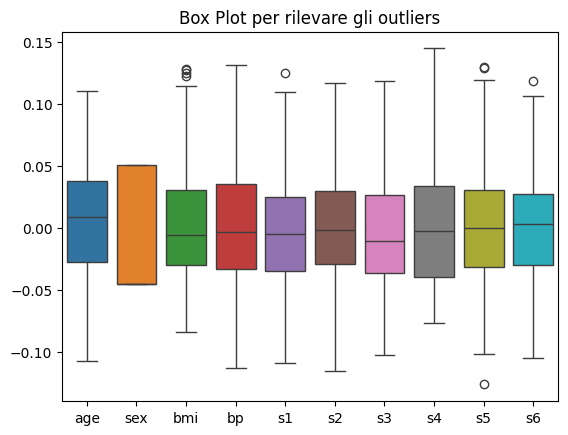

In [24]:
# Box plot
sns.boxplot(data=X_train_noOut)
plt.title('Box Plot per rilevare gli outliers')
plt.show()

In [25]:
# Alleno il modello sui dati di training una volta rimossi gli outliers
model.fit(X_train_noOut, y_train_noOut)

# Faccio delle predizioni sui dati di test
y_pred = model.predict(X_val)

# Valuto le prestazioni del modello
mse_noOut = mean_squared_error(y_val, y_pred)
r2_noOut = r2_score(y_val, y_pred)
mae_noOut = mean_absolute_error(y_val, y_pred)

# Stampa i risultati
print(f'Mean Absolute Error (MAE): {mae_noOut}')
print(f'Mean Squared Error (MSE): {mse_noOut}')
print(f'R^2 Score: {r2_noOut}')

Mean Absolute Error (MAE): 46.97433553219929
Mean Squared Error (MSE): 3259.927899433393
R^2 Score: 0.4562796644869588


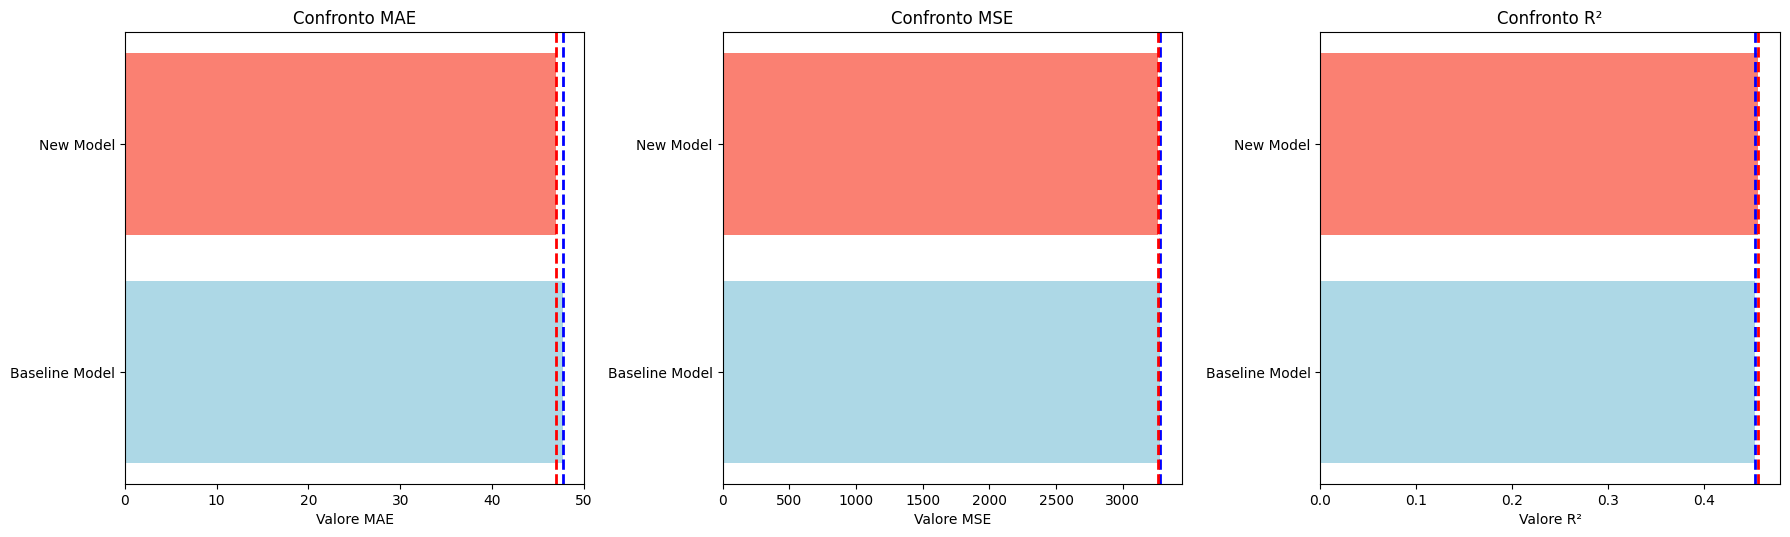

In [26]:
def plot_comparison_metrics(mae_blm, mse_blm, r2_blm, mae, mse, r2):
    # Creazione delle metriche da confrontare
    metrics = ['MAE', 'MSE', 'R²']
    baseline_values = [mae_blm, mse_blm, r2_blm]
    new_model_values = [mae, mse, r2]

    # Creo una figura con 3 sottotrame
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Grafico MAE
    axes[0].barh(['Baseline Model', 'New Model'], [mae_blm, mae], color=['lightblue', 'salmon'])
    axes[0].set_title('Confronto MAE')
    axes[0].set_xlabel('Valore MAE')

    # Grafico MSE
    axes[1].barh(['Baseline Model', 'New Model'], [mse_blm, mse], color=['lightblue', 'salmon'])
    axes[1].set_title('Confronto MSE')
    axes[1].set_xlabel('Valore MSE')

    # Grafico R²
    axes[2].barh(['Baseline Model', 'New Model'], [r2_blm, r2], color=['lightblue', 'salmon'])
    axes[2].set_title('Confronto R²')
    axes[2].set_xlabel('Valore R²')


    # Aggiungo le linee di riferimento per mostrare la differenza
    for ax, baseline, new in zip(axes, baseline_values, new_model_values):
        ax.axvline(x=baseline, color='blue', linestyle='dashed', linewidth=2)
        ax.axvline(x=new, color='red', linestyle='dashed', linewidth=2)

    # Mostrare il grafico
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Spazio per il titolo
    plt.show()

plot_comparison_metrics(mae_blm, mse_blm, r2_blm, mae_noOut, mse_noOut, r2_noOut)

Rimuovere gli outliers dal training set ha migliorato le prestazioni: Questo suggerisce che gli outliers stavano influenzando negativamente il modello.

<span style="color: red; font-size: 18px; font-weight: bold;">
Selezione delle features
</span>

<div style="background-color:  #E0FFFF; padding: 10px;">
    Presenza di correlazioni lineari nel train set?
</div>

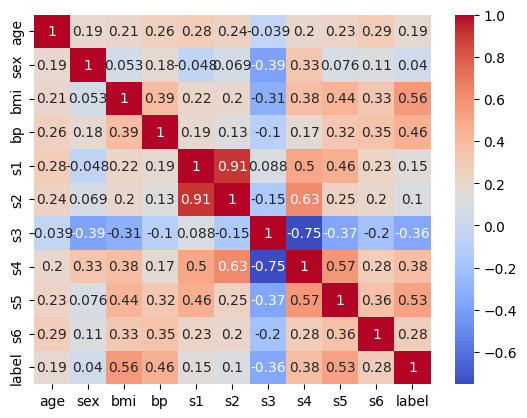

In [27]:
# Aggiungi y come una colonna di X per calcolare la matrice di correlazione
df_train_noOut = X_train_noOut.copy()
df_train_noOut['label'] = y_train_noOut

# Calcolare la matrice di correlazione
corr_matrix = df_train_noOut.corr()

# Visualizzare la matrice di correlazione con una heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [28]:
corr_matrix["label"].sort_values(ascending=False)

,label
label,1.000000
bmi,0.556569
s5,0.526904
bp,0.458036
s4,0.380505
s6,0.276357
age,0.188570
s1,0.149649
s2,0.103745
sex,0.040121


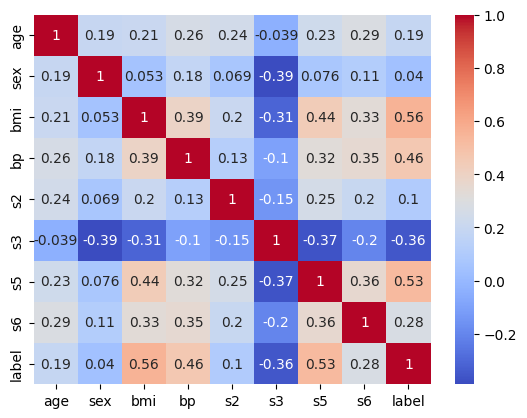

In [29]:
''' Data la presenza di features che correlano tra di loro,  la multicollinearità potrebbe avere un impatto negativo sulle prestazioni del modello
    di regressione lineare.
    Per mitigare questo problema, si è deciso di ridurre il set di dati di train e test rimuovendo le features correlate tra loro.
    In particolare, sono state rimosse le variabili s1 e s4, poiché la loro esclusione ha eliminato le principali correlazioni tra le features,
    consentendo di mantenere quelle con una correlazione più elevata con la variabile target (label). '''
X_train_ridotto_noOut = X_train_noOut.drop(columns=['s1', 's4'])
X_val_ridotto = X_val.drop(columns=['s1', 's4'])

# Aggiungi y come una colonna di X per calcolare la matrice di correlazione
df_train_ridotto_noOut = X_train_ridotto_noOut.copy()
df_train_ridotto_noOut['label'] = y_train_noOut

# Calcolare la matrice di correlazione
corr_matrix = df_train_ridotto_noOut.corr()

# Visualizzare la matrice di correlazione con una heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [30]:
# Alleno il modello sui dati di training
model.fit(X_train_ridotto_noOut, y_train_noOut)

# Faccio delle predizioni sui dati di test
y_pred = model.predict(X_val_ridotto)

# Valuto le prestazioni del modello
mse_ridotto_noOut = mean_squared_error(y_val, y_pred)
r2_ridotto_noOut = r2_score(y_val, y_pred)
mae_ridotto_noOut = mean_absolute_error(y_val, y_pred)

# Stampa i risultati
print(f'Mean Absolute Error (MAE): {mae_ridotto_noOut}')
print(f'Mean Squared Error (MSE): {mse_ridotto_noOut}')
print(f'R^2 Score: {r2_ridotto_noOut}')

Mean Absolute Error (MAE): 46.85043369547194
Mean Squared Error (MSE): 3263.787458897062
R^2 Score: 0.4556359321618103


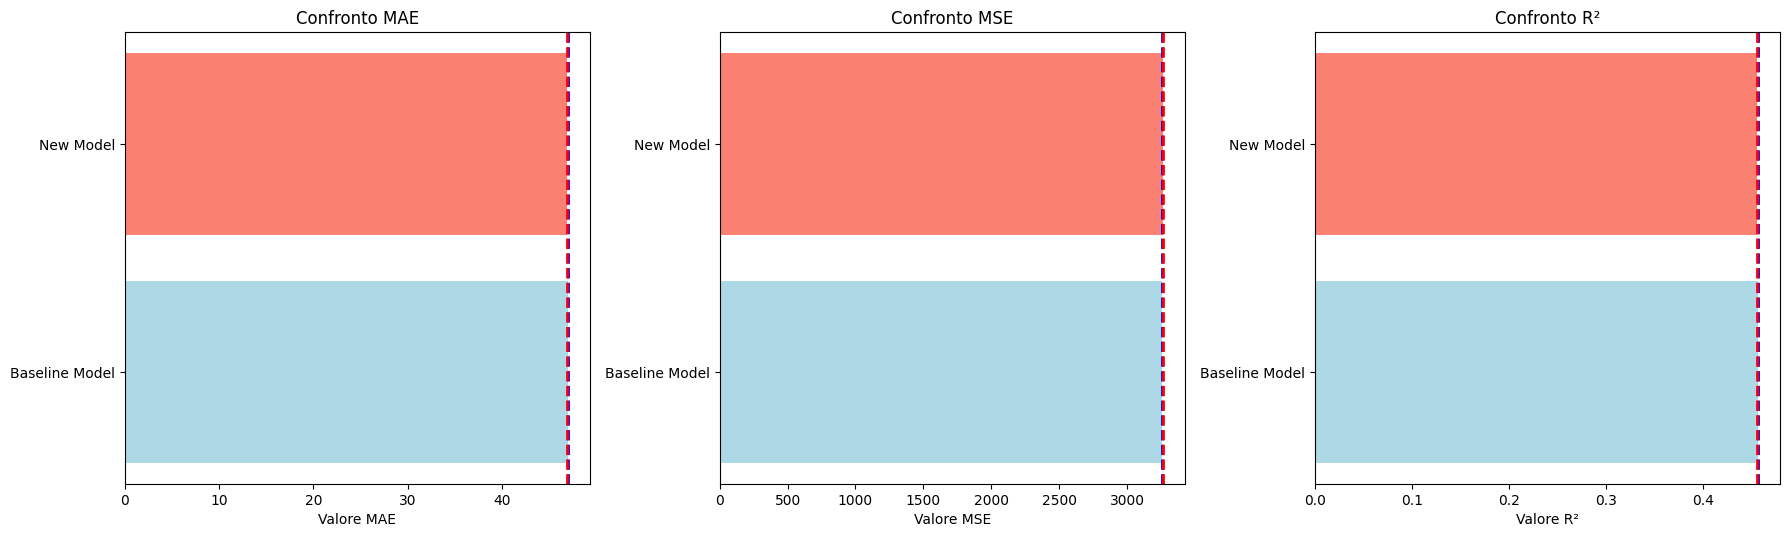

In [31]:
plot_comparison_metrics(mae_noOut, mse_noOut, r2_noOut, mae_ridotto_noOut, mse_ridotto_noOut, r2_ridotto_noOut)

Rimuovere le feature altamente correlate tra loro ha portato a un lieve miglioramento delle prestazioni del modello in termini di MAE ma non in termini di MSE.

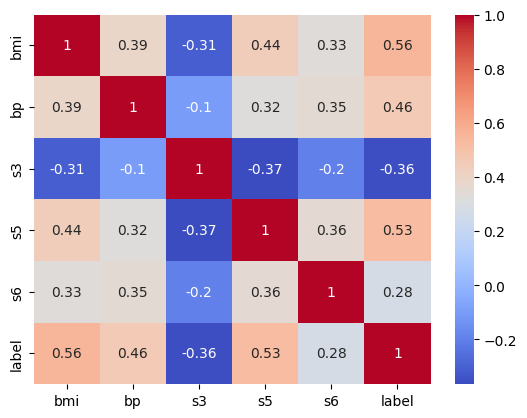

In [32]:
''' Dato che solo alcune feature sembrano correlare linearmente con le labels vediamo se selezionando solo le features maggiormente correlate con
    le labels, i risultati migliorano'''
X_train_ridotto2_noOut = X_train_ridotto_noOut.drop(columns=['sex', 'age', 's2'])
X_val_ridotto2 = X_val_ridotto.drop(columns=['sex', 'age', 's2'])

# Aggiungo y come una colonna di X per calcolare la matrice di correlazione
df_train_ridotto2_noOut = X_train_ridotto2_noOut.copy()
df_train_ridotto2_noOut['label'] = y_train_noOut

# Calcolo la matrice
corr_matrix = df_train_ridotto2_noOut.corr()

# Visualizzare la matrice
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [33]:
# Alleno il modello sui dati di training
model.fit(X_train_ridotto2_noOut, y_train_noOut)

# Faccio delle predizioni sui dati di test
y_pred = model.predict(X_val_ridotto2)

# Valuto le prestazioni del modello
mse_ridotto2_noOut = mean_squared_error(y_val, y_pred)
r2_ridotto2_noOut = r2_score(y_val, y_pred)
mae_ridotto2_noOut = mean_absolute_error(y_val, y_pred)

# Stampa i risultati
print(f'Mean Absolute Error (MAE): {mae_ridotto2_noOut}')
print(f'Mean Squared Error (MSE): {mse_ridotto2_noOut}')
print(f'R^2 Score: {r2_ridotto2_noOut}')

Mean Absolute Error (MAE): 48.1609559440681
Mean Squared Error (MSE): 3466.2024044351565
R^2 Score: 0.42187533208229455


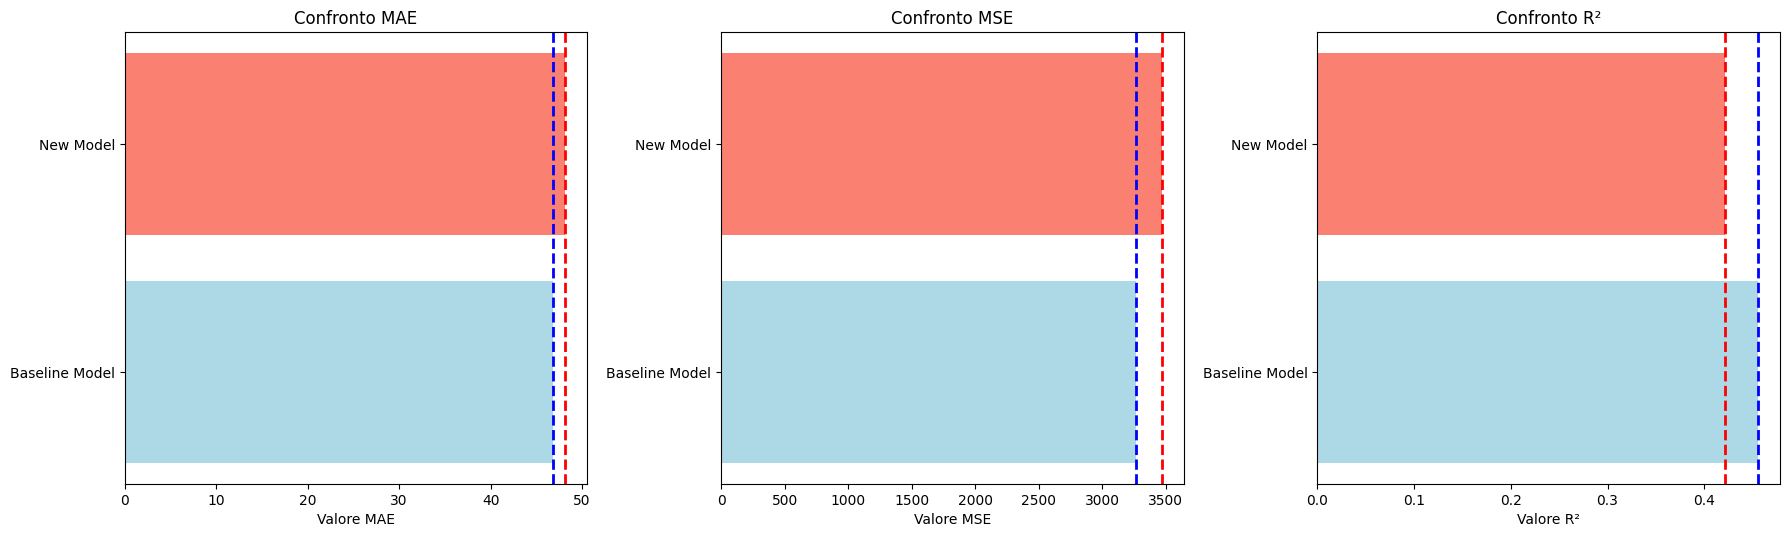

In [34]:
plot_comparison_metrics(mae_ridotto_noOut, mse_ridotto_noOut, r2_ridotto_noOut, mae_ridotto2_noOut, mse_ridotto2_noOut, r2_ridotto2_noOut)

Rimuovere ulteriormente le feature poco correlate con le labels ha peggiorato le prestazioni: Questo suggerisce che sono state rimosse informazioni utili che avrebbero potuto contribuire alla previsione.

**Risultati Baseline (BLM)**

- La rimozione degli outliers migliora leggermente il modello, riducendo sia il MSE che il MAE. Sebbene non sia una riduzione radicale, l'effetto della rimozione degli outliers si dimostra positivo, indicando che la presenza di outliers possa influenzare negativamente le performance del modello.
Baseline Model senza outlier con riduzione multicollinearità:

- La riduzione della multicollinearità sembra avere un impatto minore rispetto alla semplice rimozione degli outliers. Il miglioramento è piccolo rispetto al modello precedente e si visualizza solo per la MAE, suggerendo che, in questo caso, la multicollinearità non influisce in modo significativo sul modello.

- La selezione delle sole feature piu correlate alla label peggiorano le performance.

# 6. Metodi per ridurre la multicolinearità


Poiché si è osservata una colinearità tra alcune delle features, il che può compromettere le prestazioni della **regressione lineare** a causa dell'effetto della **multicollinearità**, si è tentato inizialmente di ridurre il set di dati rimuovendo manualmente due variabili fortemente correlate. Tuttavia, questa rimozione non ha portato a un miglioramento significativo delle prestazioni del modello. Di conseguenza, si è deciso di provare due modelli che, grazie alla loro natura, sono in grado di ridurre l'impatto delle correlazioni tra le variabili: **Lasso e Ridge Regression**. Entrambi i modelli applicano una penalizzazione sui coefficienti delle features, riducendo l'importanza delle variabili collineari e migliorando la stabilità e l'accuratezza delle predizioni.

<span style="color: red; font-size: 18px; font-weight: bold;">
Lasso e Ridge
</span>

Minimo MSE per Ridge: 3183.0861574927794 a alpha = 0.13
Minimo MSE per Lasso: 3228.8870788518384 a alpha = 0.04
Minimo MAE per Ridge: 47.02842701141099 a alpha = 0.23
Minimo MAE per Lasso: 47.45061482151542 a alpha = 0.01
Massimo R² per Ridge: 0.4690960269950434 a alpha = 0.13
Massimo R² per Lasso: 0.4614569340161826 a alpha = 0.04


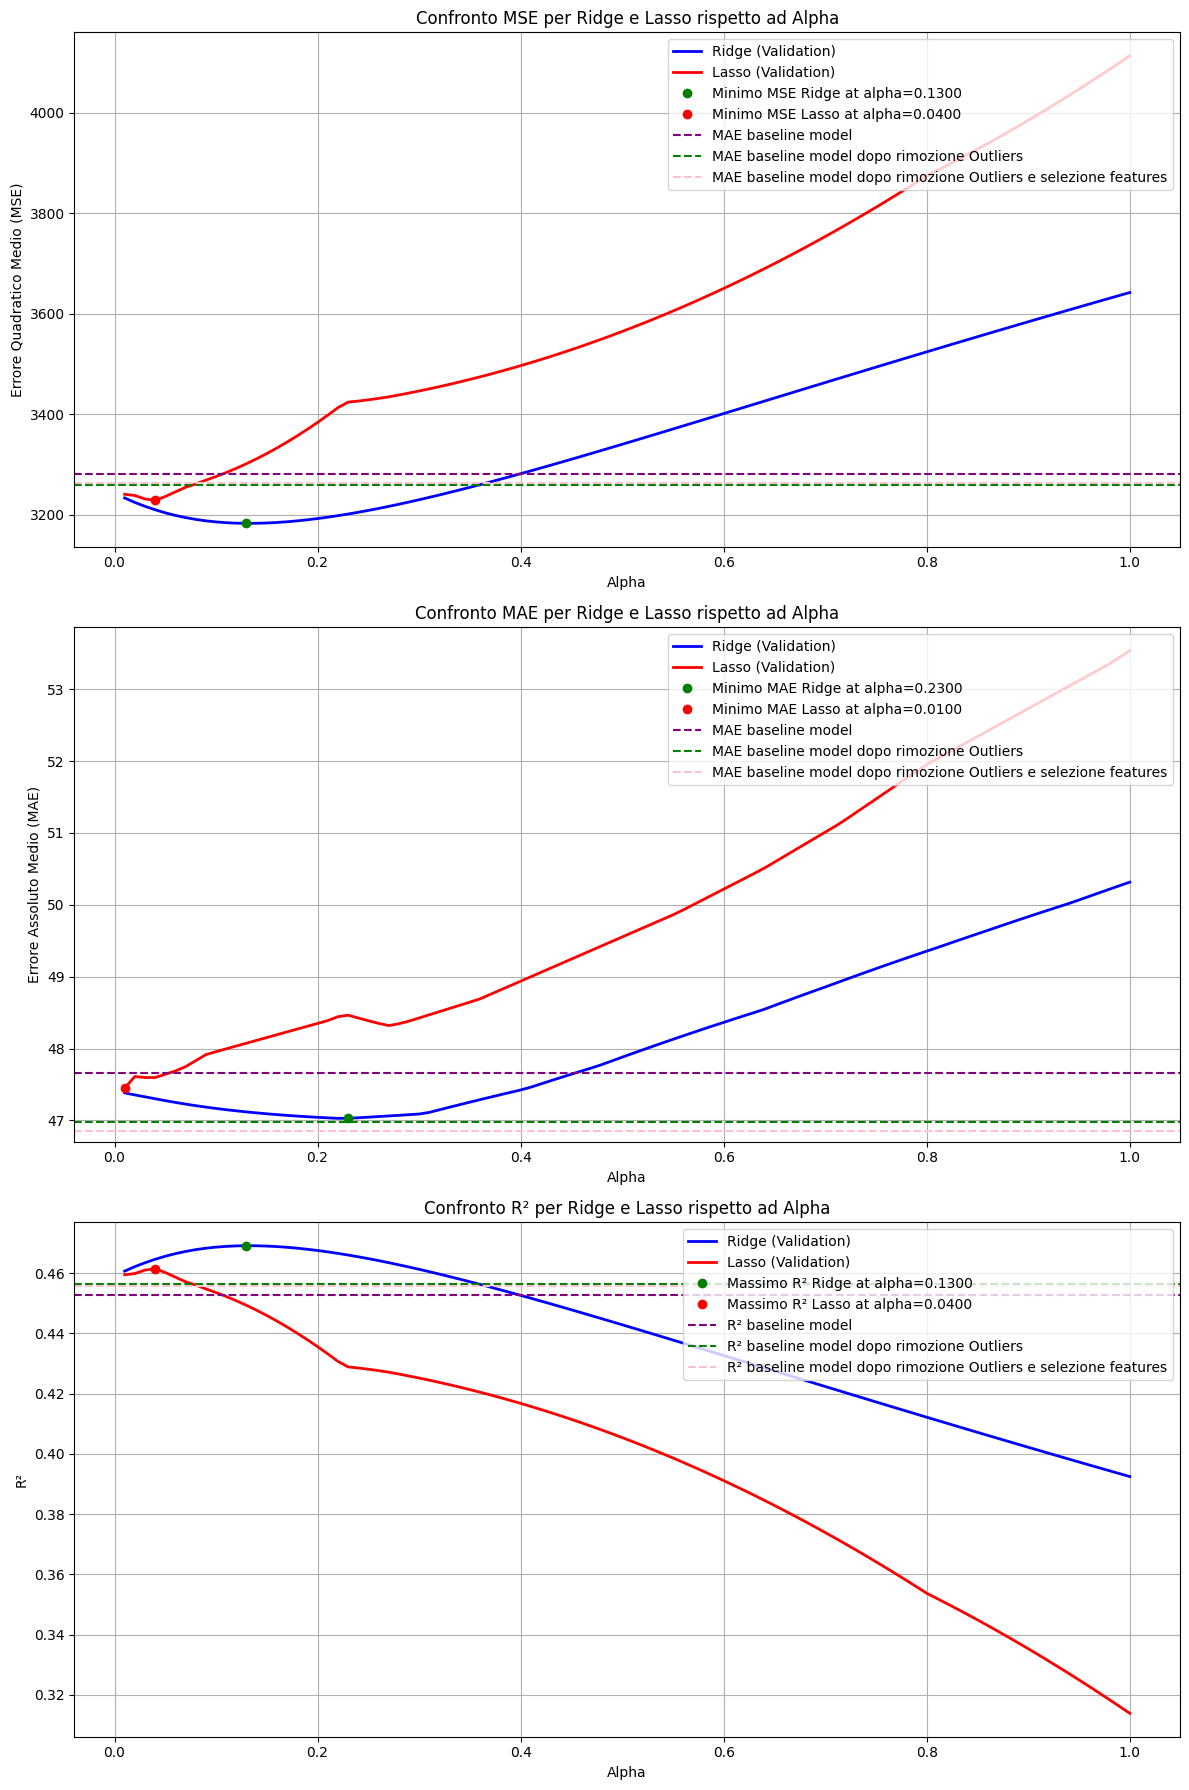

{'min_ridge_mse': 3183.0861574927794,
 'min_ridge_mse_alpha': 0.13,
 'min_lasso_mse': 3228.8870788518384,
 'min_lasso_mse_alpha': 0.04,
 'min_ridge_mae': 47.02842701141099,
 'min_ridge_mae_alpha': 0.23,
 'min_lasso_mae': 47.45061482151542,
 'min_lasso_mae_alpha': 0.01,
 'max_ridge_r2': 0.4690960269950434,
 'max_ridge_r2_alpha': 0.13,
 'max_lasso_r2': 0.4614569340161826,
 'max_lasso_r2_alpha': 0.04}

In [35]:
def compare_ridge_lasso(X_train, y_train, X_val, y_val, alpha_values=np.linspace(0.01, 1, 100)):
    # Liste per memorizzare i MSE, MAE e R²
    ridge_mse_val = []
    lasso_mse_val = []
    ridge_mae_val = []
    lasso_mae_val = []
    ridge_r2_val = []
    lasso_r2_val = []

    # Test per Ridge Regression
    for alpha in alpha_values:
        # Modello Ridge con l'alpha corrente
        ridge = Ridge(alpha=alpha)
        # Alleno il modello sui dati di training
        ridge.fit(X_train, y_train)

        # Calcolo le predizioni sul validation set
        y_pred_val = ridge.predict(X_val)

        # Calcolo MSE, MAE e R² sui dati di validazione
        mse_val = mean_squared_error(y_val, y_pred_val)
        mae_val = mean_absolute_error(y_val, y_pred_val)
        r2_val = r2_score(y_val, y_pred_val)

        # Memorizzazione i valori
        ridge_mse_val.append(mse_val)
        ridge_mae_val.append(mae_val)
        ridge_r2_val.append(r2_val)

    # Test per Lasso Regression
    for alpha in alpha_values:
        # Modello Lasso con l'alpha corrente
        lasso = Lasso(alpha=alpha)
        # Alleno il modello sui dati di training
        lasso.fit(X_train, y_train)

        # Calcolo le predizioni sul validation set
        y_pred_val = lasso.predict(X_val)

        # Calcolo MSE, MAE e R² sui dati di validazione
        mse_val = mean_squared_error(y_val, y_pred_val)
        mae_val = mean_absolute_error(y_val, y_pred_val)
        r2_val = r2_score(y_val, y_pred_val)

        # Memorizzo i valori
        lasso_mse_val.append(mse_val)
        lasso_mae_val.append(mae_val)
        lasso_r2_val.append(r2_val)

    # Trovo il minimo della curva MSE di Ridge e Lasso
    min_ridge_mse = min(ridge_mse_val)
    min_ridge_mse_alpha = alpha_values[ridge_mse_val.index(min_ridge_mse)]
    min_lasso_mse = min(lasso_mse_val)
    min_lasso_mse_alpha = alpha_values[lasso_mse_val.index(min_lasso_mse)]

    # Trovo il minimo della curva MAE di Ridge e Lasso
    min_ridge_mae = min(ridge_mae_val)
    min_ridge_mae_alpha = alpha_values[ridge_mae_val.index(min_ridge_mae)]
    min_lasso_mae = min(lasso_mae_val)
    min_lasso_mae_alpha = alpha_values[lasso_mae_val.index(min_lasso_mae)]

    # Trovo il massimo della curva R² di Ridge e Lasso
    max_ridge_r2 = max(ridge_r2_val)
    max_ridge_r2_alpha = alpha_values[ridge_r2_val.index(max_ridge_r2)]
    max_lasso_r2 = max(lasso_r2_val)
    max_lasso_r2_alpha = alpha_values[lasso_r2_val.index(max_lasso_r2)]

    # Stampa i valori minimi e le coordinate dei punti di massimo
    print(f'Minimo MSE per Ridge: {min_ridge_mse} a alpha = {min_ridge_mse_alpha}')
    print(f'Minimo MSE per Lasso: {min_lasso_mse} a alpha = {min_lasso_mse_alpha}')
    print(f'Minimo MAE per Ridge: {min_ridge_mae} a alpha = {min_ridge_mae_alpha}')
    print(f'Minimo MAE per Lasso: {min_lasso_mae} a alpha = {min_lasso_mae_alpha}')
    print(f'Massimo R² per Ridge: {max_ridge_r2} a alpha = {max_ridge_r2_alpha}')
    print(f'Massimo R² per Lasso: {max_lasso_r2} a alpha = {max_lasso_r2_alpha}')

    # Creazione dei subplot
    fig, axes = plt.subplots(3, 1, figsize=(12, 18))

    # Plot MSE per Ridge e Lasso
    axes[0].plot(alpha_values, ridge_mse_val, label="Ridge (Validation)", color='blue', lw=2)
    axes[0].plot(alpha_values, lasso_mse_val, label="Lasso (Validation)", color='red', lw=2)
    axes[0].set_xlabel('Alpha')
    axes[0].set_ylabel('Errore Quadratico Medio (MSE)')
    axes[0].set_title('Confronto MSE per Ridge e Lasso rispetto ad Alpha')
    axes[0].legend(loc='upper right')
    axes[0].grid(True)

    # Aggiungo il punto di minimo della curva Ridge e Lasso (MSE) per migliore leggibilità
    axes[0].plot(min_ridge_mse_alpha, min_ridge_mse, 'go', label=f'Minimo MSE Ridge at alpha={min_ridge_mse_alpha:.4f}')
    axes[0].plot(min_lasso_mse_alpha, min_lasso_mse, 'ro', label=f'Minimo MSE Lasso at alpha={min_lasso_mse_alpha:.4f}')

    # Aggiungo una linea orizzontale per mse_blm
    axes[0].axhline(y=mse_blm, color='purple', linestyle='--', label="MAE baseline model")
    axes[0].axhline(y=mse_noOut, color='green', linestyle='--', label="MAE baseline model dopo rimozione Outliers")
    axes[0].axhline(y=mse_ridotto_noOut, color='pink', linestyle='--', label="MAE baseline model dopo rimozione Outliers e selezione features")
    axes[0].legend(loc='upper right')

    # Plot MAE per Ridge e Lasso
    axes[1].plot(alpha_values, ridge_mae_val, label="Ridge (Validation)", color='blue', lw=2)
    axes[1].plot(alpha_values, lasso_mae_val, label="Lasso (Validation)", color='red', lw=2)
    axes[1].set_xlabel('Alpha')
    axes[1].set_ylabel('Errore Assoluto Medio (MAE)')
    axes[1].set_title('Confronto MAE per Ridge e Lasso rispetto ad Alpha')
    axes[1].legend(loc='upper right')
    axes[1].grid(True)

    # Aggiungo il punto di minimo della curva Ridge e Lasso (MAE)
    axes[1].plot(min_ridge_mae_alpha, min_ridge_mae, 'go', label=f'Minimo MAE Ridge at alpha={min_ridge_mae_alpha:.4f}')
    axes[1].plot(min_lasso_mae_alpha, min_lasso_mae, 'ro', label=f'Minimo MAE Lasso at alpha={min_lasso_mae_alpha:.4f}')

    # Aggiungo una linea orizzontale per mae_blm
    axes[1].axhline(y=mae_blm, color='purple', linestyle='--', label="MAE baseline model")
    axes[1].axhline(y=mae_noOut, color='green', linestyle='--', label="MAE baseline model dopo rimozione Outliers")
    axes[1].axhline(y=mae_ridotto_noOut, color='pink', linestyle='--', label="MAE baseline model dopo rimozione Outliers e selezione features")
    axes[1].legend(loc = 'upper right')

    # Plot R² per Ridge e Lasso
    axes[2].plot(alpha_values, ridge_r2_val, label="Ridge (Validation)", color='blue', lw=2)
    axes[2].plot(alpha_values, lasso_r2_val, label="Lasso (Validation)", color='red', lw=2)
    axes[2].set_xlabel('Alpha')
    axes[2].set_ylabel('R²')
    axes[2].set_title('Confronto R² per Ridge e Lasso rispetto ad Alpha')
    axes[2].legend(loc='upper right')
    axes[2].grid(True)

    # Aggiungo il punto di massimo della curva Ridge e Lasso (R²)
    axes[2].plot(max_ridge_r2_alpha, max_ridge_r2, 'go', label=f'Massimo R² Ridge at alpha={max_ridge_r2_alpha:.4f}')
    axes[2].plot(max_lasso_r2_alpha, max_lasso_r2, 'ro', label=f'Massimo R² Lasso at alpha={max_lasso_r2_alpha:.4f}')

    # Aggiungo una linea orizzontale per r2_blm
    axes[2].axhline(y=r2_blm, color='purple', linestyle='--', label="R² baseline model")
    axes[2].axhline(y=r2_noOut, color='green', linestyle='--', label="R² baseline model dopo rimozione Outliers")
    axes[2].axhline(y=r2_ridotto_noOut, color='pink', linestyle='--', label="R² baseline model dopo rimozione Outliers e selezione features")
    axes[2].legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # Restituisce anche i risultati (MSE, MAE e R² minimi) per poterli salvare in variabili qual'ora dovessimo riusarli
    return {
        'min_ridge_mse': min_ridge_mse,
        'min_ridge_mse_alpha': min_ridge_mse_alpha,
        'min_lasso_mse': min_lasso_mse,
        'min_lasso_mse_alpha': min_lasso_mse_alpha,
        'min_ridge_mae': min_ridge_mae,
        'min_ridge_mae_alpha': min_ridge_mae_alpha,
        'min_lasso_mae': min_lasso_mae,
        'min_lasso_mae_alpha': min_lasso_mae_alpha,
        'max_ridge_r2': max_ridge_r2,
        'max_ridge_r2_alpha': max_ridge_r2_alpha,
        'max_lasso_r2': max_lasso_r2,
        'max_lasso_r2_alpha': max_lasso_r2_alpha
    }



# Chiamata alla funzione:
alpha_values=np.linspace(0.01, 1, 100)
compare_ridge_lasso(X_train, y_train, X_val, y_val, alpha_values=alpha_values)


Poichè si vede in maniera evidente che oltre i valori di alpha = 0.3 gli errori MAE e MSE tendono a crescere e r2 a diminuire ci concentriamo sull'intervallo di alpha tra 0.01 e 0.03

Minimo MSE per Ridge: 3183.072237212722 a alpha = 0.13303030303030303
Minimo MSE per Lasso: 3228.0951905383754 a alpha = 0.03636363636363636
Minimo MAE per Ridge: 47.02588038027189 a alpha = 0.22676767676767676
Minimo MAE per Lasso: 47.45061482151542 a alpha = 0.01
Massimo R² per Ridge: 0.4690983487455779 a alpha = 0.13303030303030303
Massimo R² per Lasso: 0.4615890123298041 a alpha = 0.03636363636363636


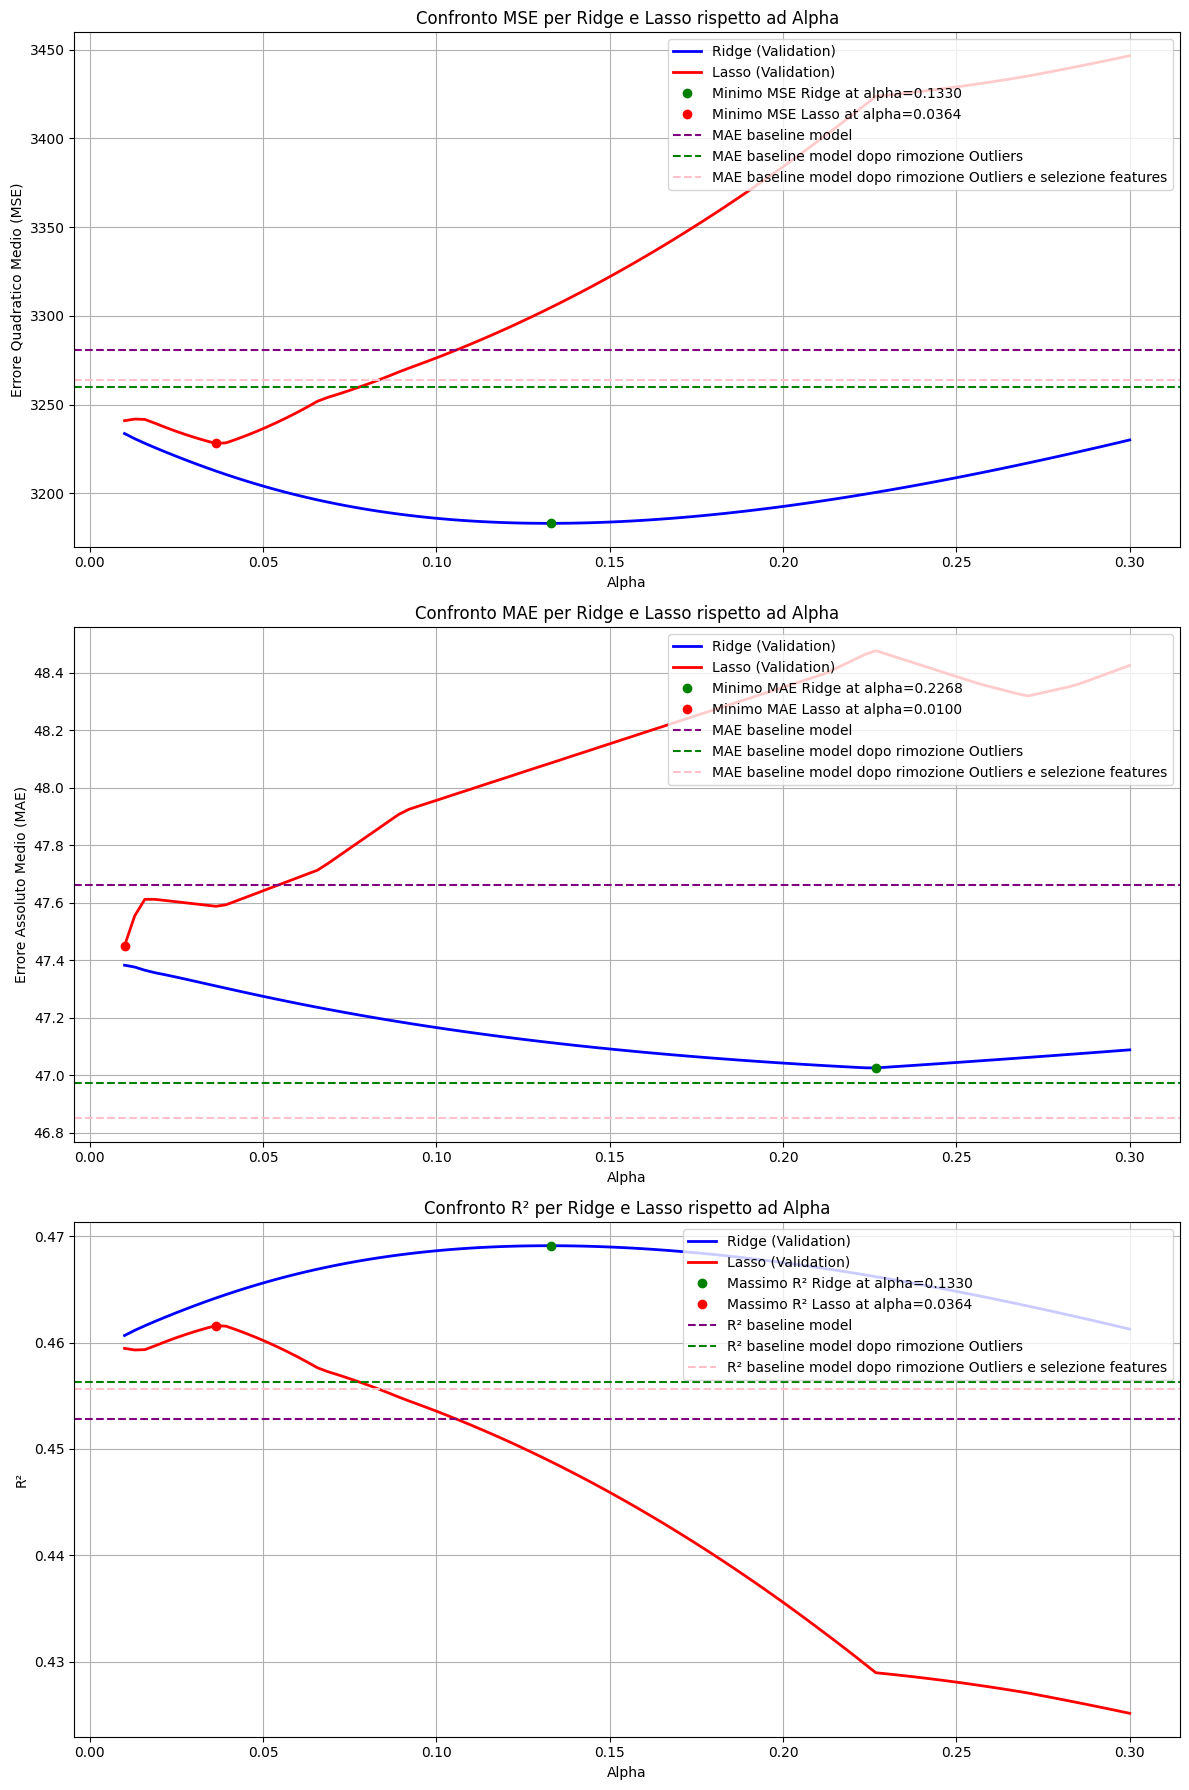

{'min_ridge_mse': 3183.072237212722,
 'min_ridge_mse_alpha': 0.13303030303030303,
 'min_lasso_mse': 3228.0951905383754,
 'min_lasso_mse_alpha': 0.03636363636363636,
 'min_ridge_mae': 47.02588038027189,
 'min_ridge_mae_alpha': 0.22676767676767676,
 'min_lasso_mae': 47.45061482151542,
 'min_lasso_mae_alpha': 0.01,
 'max_ridge_r2': 0.4690983487455779,
 'max_ridge_r2_alpha': 0.13303030303030303,
 'max_lasso_r2': 0.4615890123298041,
 'max_lasso_r2_alpha': 0.03636363636363636}

In [36]:
# Chiamata alla funzione:
alpha_values=np.linspace(0.01, 0.3, 100)
compare_ridge_lasso(X_train, y_train, X_val, y_val, alpha_values=alpha_values)

### - Rimozione Outliers

Poiché, come evidenziato dal modello baseline, gli outliers sembrano influire negativamente sulle predizioni e, dato che Lasso e Ridge da soli non gestiscono efficacemente questi valori (anzi, li amplificano in alcuni casi), riapplicheremo il modello dopo aver rimosso gli outliers.

Minimo MSE per Ridge: 3185.815817077804 a alpha = 0.11
Minimo MSE per Lasso: 3208.629089782353 a alpha = 0.05
Minimo MAE per Ridge: 46.63937130900867 a alpha = 0.13
Minimo MAE per Lasso: 46.679182351227915 a alpha = 0.05
Massimo R² per Ridge: 0.4686407496173861 a alpha = 0.11
Massimo R² per Lasso: 0.4648357451290279 a alpha = 0.05


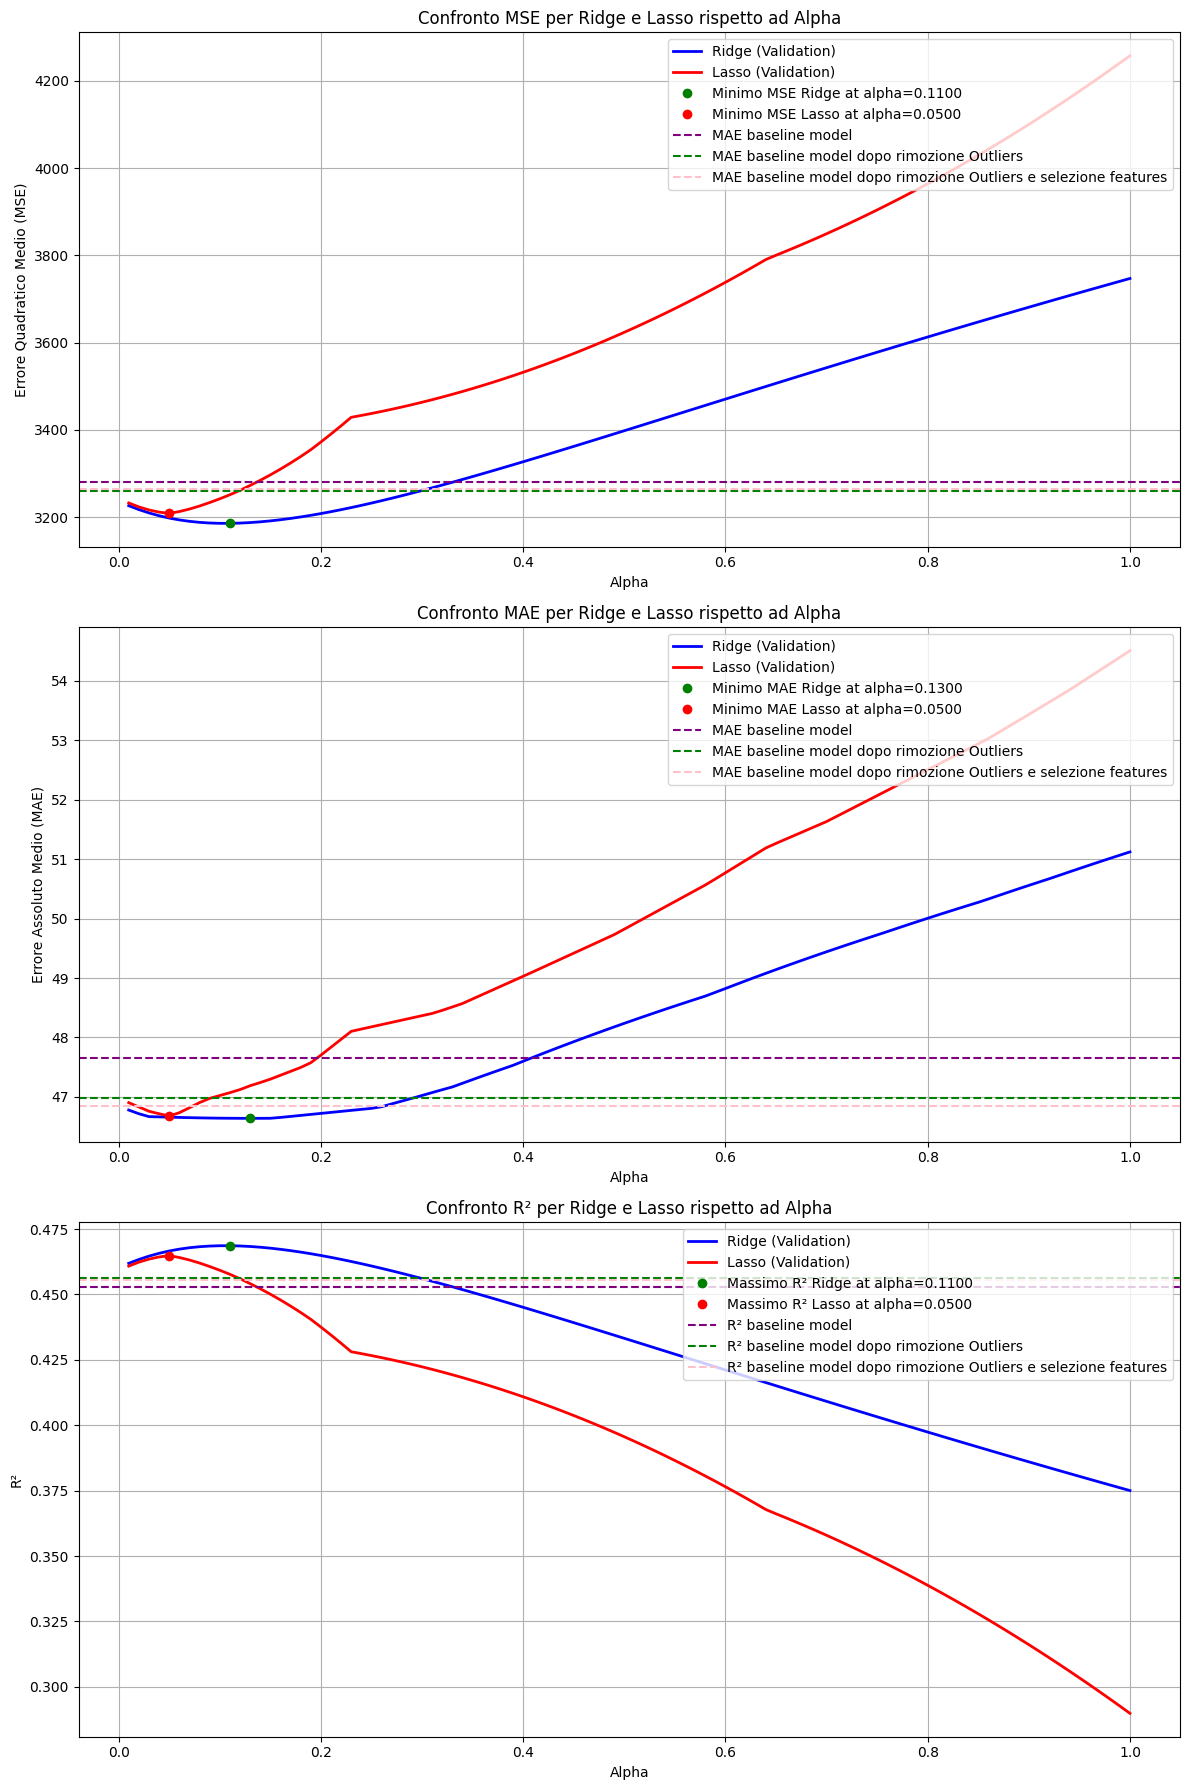

{'min_ridge_mse': 3185.815817077804,
 'min_ridge_mse_alpha': 0.11,
 'min_lasso_mse': 3208.629089782353,
 'min_lasso_mse_alpha': 0.05,
 'min_ridge_mae': 46.63937130900867,
 'min_ridge_mae_alpha': 0.13,
 'min_lasso_mae': 46.679182351227915,
 'min_lasso_mae_alpha': 0.05,
 'max_ridge_r2': 0.4686407496173861,
 'max_ridge_r2_alpha': 0.11,
 'max_lasso_r2': 0.4648357451290279,
 'max_lasso_r2_alpha': 0.05}

In [37]:
# Chiamata alla funzione:
alpha_values=np.linspace(0.01, 1, 100)
compare_ridge_lasso(X_train_noOut, y_train_noOut, X_val, y_val, alpha_values=alpha_values)

Qui l'aumento evidente degli errori si ha per alpha > 0.2. Limitiamo a alpha [0,0.2] l'intervallo

Minimo MSE per Ridge: 3185.7549416401557 a alpha = 0.10595959595959595
Minimo MSE per Lasso: 3208.571782512836 a alpha = 0.05030303030303031
Minimo MAE per Ridge: 46.63937046801977 a alpha = 0.13090909090909092
Minimo MAE per Lasso: 46.674941538413336 a alpha = 0.052222222222222225
Massimo R² per Ridge: 0.46865090297488454 a alpha = 0.10595959595959595
Massimo R² per Lasso: 0.4648453033550901 a alpha = 0.05030303030303031


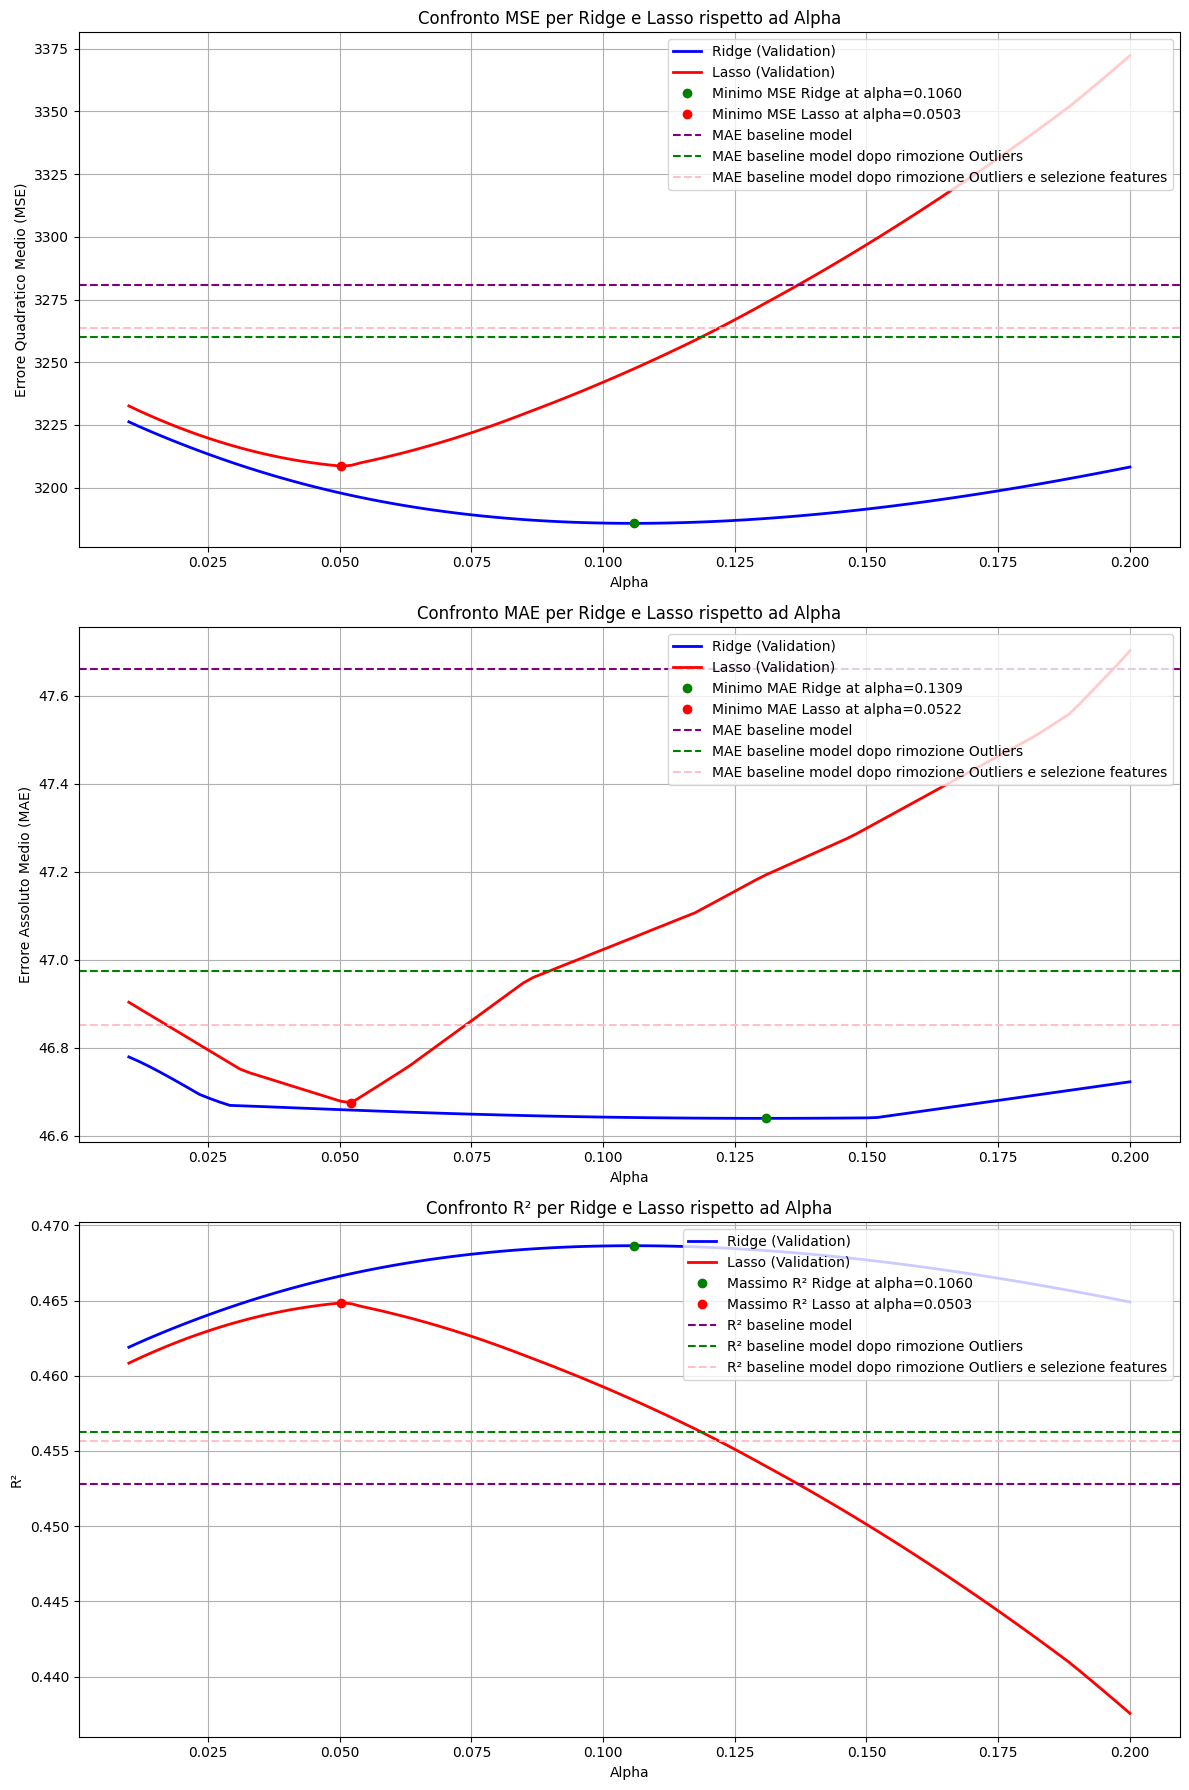

{'min_ridge_mse': 3185.7549416401557,
 'min_ridge_mse_alpha': 0.10595959595959595,
 'min_lasso_mse': 3208.571782512836,
 'min_lasso_mse_alpha': 0.05030303030303031,
 'min_ridge_mae': 46.63937046801977,
 'min_ridge_mae_alpha': 0.13090909090909092,
 'min_lasso_mae': 46.674941538413336,
 'min_lasso_mae_alpha': 0.052222222222222225,
 'max_ridge_r2': 0.46865090297488454,
 'max_ridge_r2_alpha': 0.10595959595959595,
 'max_lasso_r2': 0.4648453033550901,
 'max_lasso_r2_alpha': 0.05030303030303031}

In [38]:
# Chiamata alla funzione:
alpha_values=np.linspace(0.01, 0.2, 100)
compare_ridge_lasso(X_train_noOut, y_train_noOut, X_val, y_val, alpha_values=alpha_values)

### - Riduzione colinearità

Proviamo a forzare ulteriormente la selezione delle features rimuovendo manualmente le feature correlate s1 e s4 come visto per il baseline model.

Minimo MSE per Ridge: 3225.096682113478 a alpha = 0.09
Minimo MSE per Lasso: 3208.257038921196 a alpha = 0.05
Minimo MAE per Ridge: 46.62415017375669 a alpha = 0.05
Minimo MAE per Lasso: 46.65430509247176 a alpha = 0.05
Massimo R² per Ridge: 0.4620891307548488 a alpha = 0.09
Massimo R² per Lasso: 0.46489779914534257 a alpha = 0.05


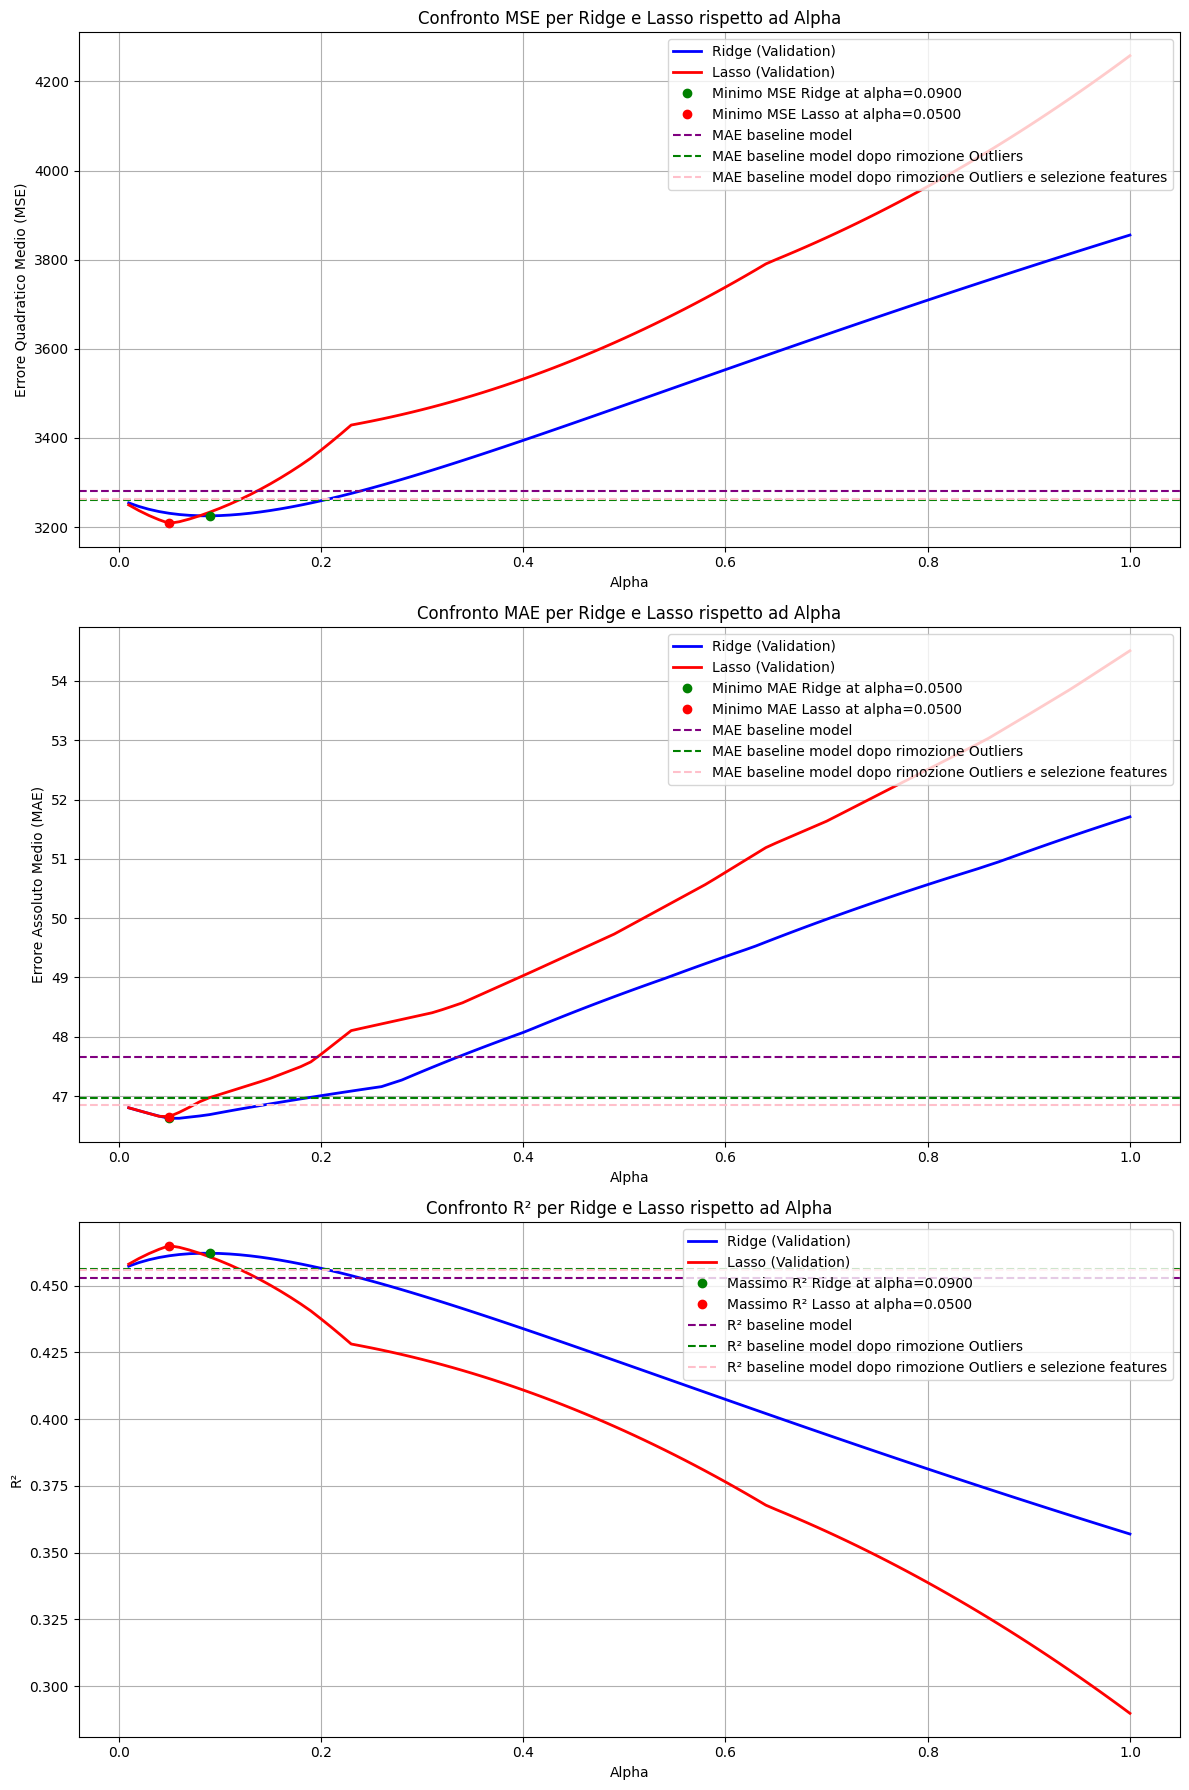

{'min_ridge_mse': 3225.096682113478,
 'min_ridge_mse_alpha': 0.09,
 'min_lasso_mse': 3208.257038921196,
 'min_lasso_mse_alpha': 0.05,
 'min_ridge_mae': 46.62415017375669,
 'min_ridge_mae_alpha': 0.05,
 'min_lasso_mae': 46.65430509247176,
 'min_lasso_mae_alpha': 0.05,
 'max_ridge_r2': 0.4620891307548488,
 'max_ridge_r2_alpha': 0.09,
 'max_lasso_r2': 0.46489779914534257,
 'max_lasso_r2_alpha': 0.05}

In [39]:
# Chiamata alla funzione:
alpha_values=np.linspace(0.01, 1, 100)
compare_ridge_lasso(X_train_ridotto_noOut, y_train_noOut, X_val_ridotto, y_val, alpha_values=alpha_values)

Limitiamo l'intervallo di alpha tra 0.01 e 0.2 dato che per alpha>0.2 osserviamo crescita degli errori MAE e MSE e riduzione di r2

Minimo MSE per Ridge: 3225.068645355463 a alpha = 0.08676767676767676
Minimo MSE per Lasso: 3207.9718888695384 a alpha = 0.052222222222222225
Minimo MAE per Ridge: 46.621360078201434 a alpha = 0.05797979797979798
Minimo MAE per Lasso: 46.65181586191467 a alpha = 0.04262626262626263
Massimo R² per Ridge: 0.4620938069795828 a alpha = 0.08676767676767676
Massimo R² per Lasso: 0.464945359056648 a alpha = 0.052222222222222225


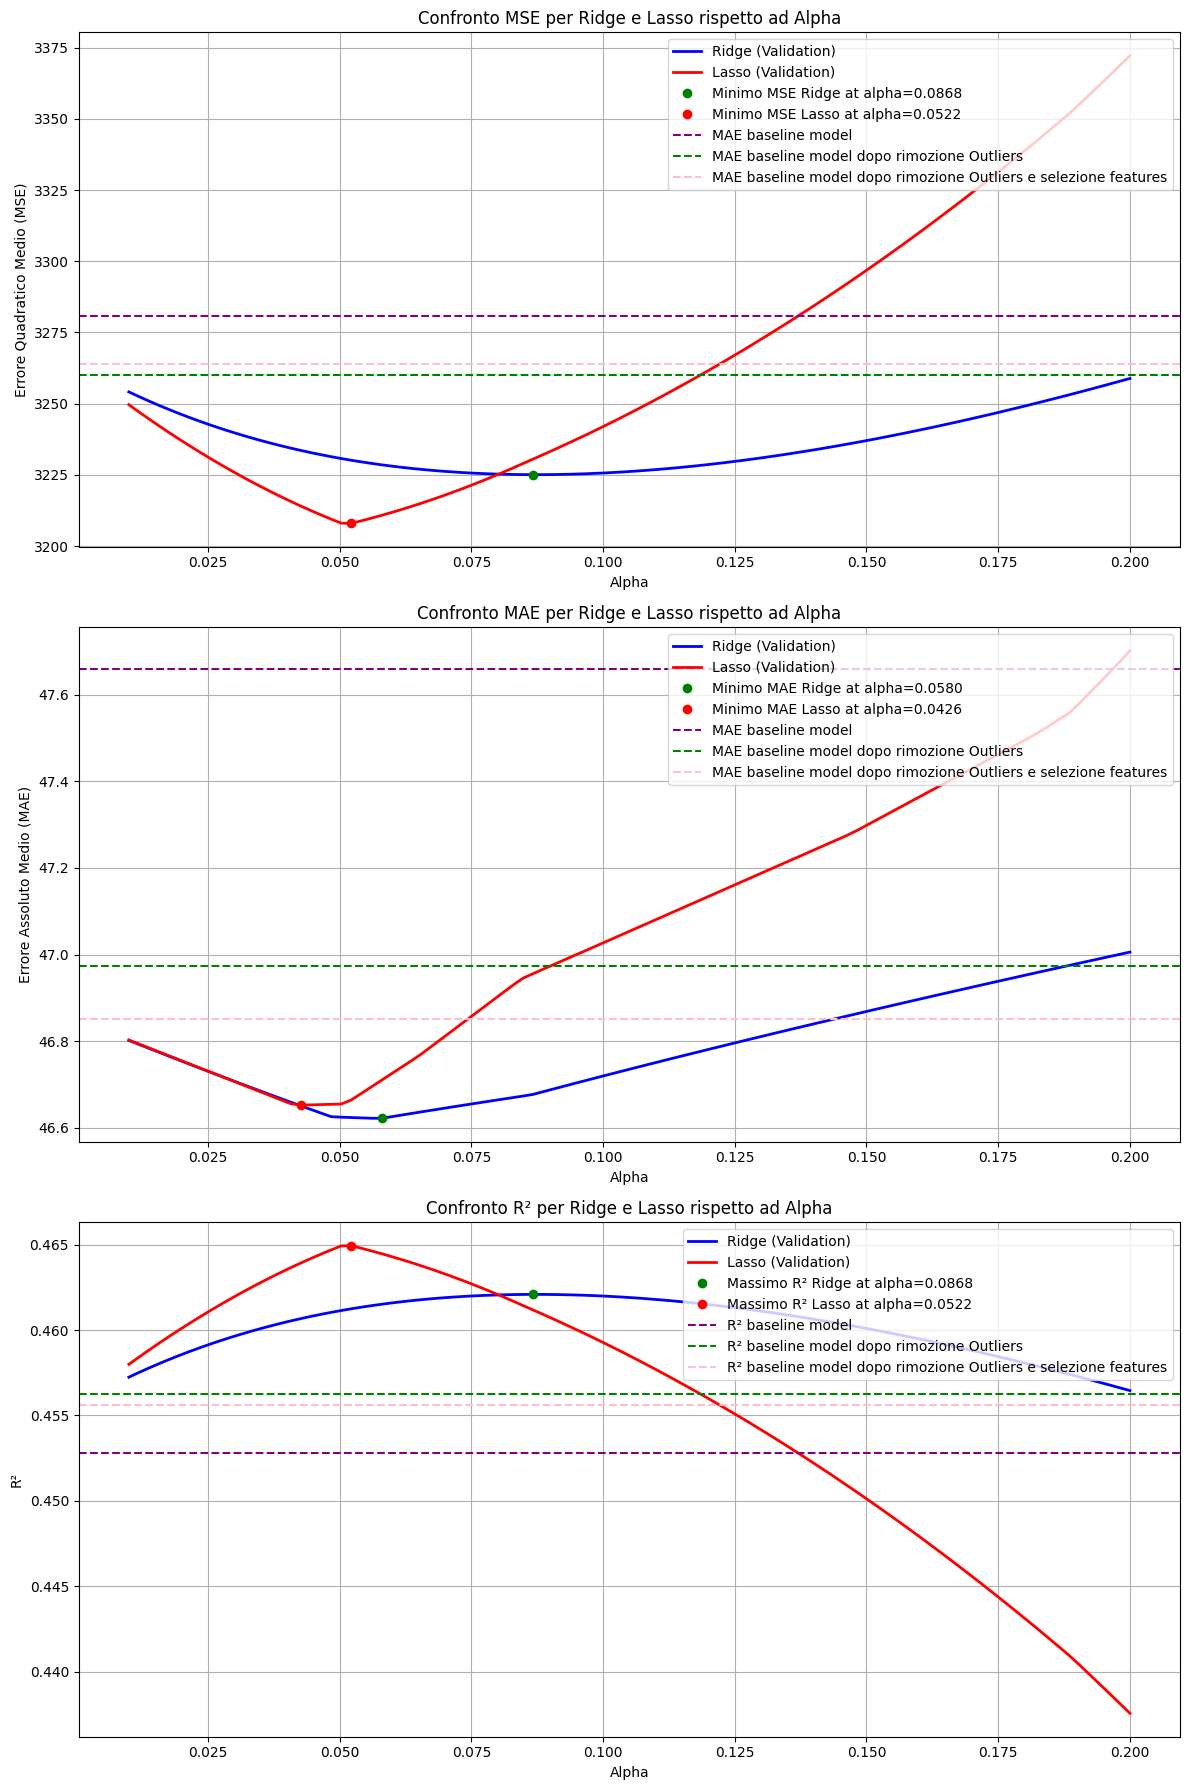

{'min_ridge_mse': 3225.068645355463,
 'min_ridge_mse_alpha': 0.08676767676767676,
 'min_lasso_mse': 3207.9718888695384,
 'min_lasso_mse_alpha': 0.052222222222222225,
 'min_ridge_mae': 46.621360078201434,
 'min_ridge_mae_alpha': 0.05797979797979798,
 'min_lasso_mae': 46.65181586191467,
 'min_lasso_mae_alpha': 0.04262626262626263,
 'max_ridge_r2': 0.4620938069795828,
 'max_ridge_r2_alpha': 0.08676767676767676,
 'max_lasso_r2': 0.464945359056648,
 'max_lasso_r2_alpha': 0.052222222222222225}

In [40]:
# Chiamata alla funzione:
alpha_values=np.linspace(0.01, 0.2, 100)
compare_ridge_lasso(X_train_ridotto_noOut, y_train_noOut, X_val_ridotto, y_val, alpha_values=alpha_values)

### 1. **Ridge e Lasso con Outliers:**

#### 1.1 **Ridge vs Lasso**
Tra **Ridge** e **Lasso**, **Ridge** mostra generalmente prestazioni migliori. **R²** risulta superiore, il che suggerisce che riesce a spiegare meglio la varianza dei dati rispetto a Lasso. Inoltre, il **MSE** e il **MAE** di Ridge sono più bassi, indicandone una migliore capacità di previsione e minore errore assoluto, il che implica una previsione più precisa in media.

#### 1.2 **Ridge e Lasso vs BLM, NoOut e Ridotto_noOut**
In presenza di outliers, sia **Ridge** che **Lasso** ottengono performance superiori rispetto a **BLM** in termini di **R2** e **MSE**. In relazione a **MAE** la **Regressione lineare** allenata su un train set **senza outliers** risulta però migliore.
La **Regressione lineare** allenata su un train set **senza outliers** potrebbe essere più precisa nel catturare la tendenza complessiva dei dati, ma potrebbe fare previsioni meno accurate su singoli punti.

---

### 2. **Ridge e Lasso senza Outliers:**

#### 2.1 **Ridge senza outliers vs Lasso senza outliers**
La differenza tra **Ridge** e **Lasso** è minima, ma **Ridge** continua a dominare leggermente.

#### 2.2 **Ridge e Lasso senza outliers vs BLM, NoOut e Ridotto_noOut**
Sia **Ridge** che **Lasso** senza outliers continuano a performare meglio rispetto agli altri modelli. I miglioramenti si percepiscono in relazione a tutte le metriche.

#### 2.3 **Ridge e Lasso senza outliers vs Ridge e Lasso con outliers**
La rimozione degli **outliers** sembra migliorare entrambi i modelli, si nota esclusivamente un leggero incremento della **MSE** per **Ridge**, di appena lo 0.06%. Sicuramente più apprezzabile è il decremento dello 0.9% di **MAE**.

---

### 3. **Ridge e Lasso senza Outliers e con Features Ridotte:**

#### 3.1 **Ridge senza outliers e con features ridotte vs Lasso senza outliers e con features ridotte**
Con la **riduzione delle features**, le prestazioni di **Ridge** e **Lasso** sono simili, con lievi differenze in **MSE** e **MAE**. Il **R²** simile indica che entrambi i modelli si adattano in modo analogo ai dati ridotti. Il miglioramento di **MSE** per **Lasso** suggerisce che la riduzione delle features può portare a una previsione leggermente più precisa.

#### 3.2 **Ridge e Lasso senza outliers e con features ridotte vs BLM, NoOut e Ridotto_noOut**
L'introduzione della **riduzione delle features** porta i modelli **Ridge** e **Lasso** a mantenere una superiorità rispetto a **BLM**, **NoOut** e **Ridotto_noOut**.

### 3.3 **Ridge e Lasso senza outliers e con features ridotte vs Ridge e Lasso senza outliers**
Il confronto tra **Ridge** e **Lasso** con e senza **riduzione delle features** mostra che la riduzione porta a una leggera perdita di adattamento (riflessa nel calo di **R²**). La riduzione porta anche a un **MSE** più elevato per **Ridge**, suggerendo che la capacità predittiva complessiva diminuisce con meno variabili. Tuttavia, il **MAE** risulta leggermente inferiore (-0.04%).


---

### Conclusione finale:
- La **rimozione degli outliers** tende a migliorare la **capacità predittiva** complessiva dei modelli Ridge e Lasso.
- La **riduzione delle caratteristiche (features)** porta a una diminuzione del valore di **R²**, con un aumento del **MSE**, indicando un impatto negativo sul potenziale predittivo, sebbene i modelli continuino a performare meglio rispetto ad altre alternative come BLM e NoOut.
- In generale, **Ridge** addestrato su un train set **senza outliers** si rivela essere il miglior modello.

---


# 7. Addestramento del modello e performance

In [ ]:
# Test degli altri parametri per il modello Ridge
''' Gli iperparametri:
    - Positivity: Quando si imposta positivity=True in Ridge Regression, i coefficienti sono forzati a essere non negativi,
        il che potrebbe distorcere i risultati dato che alcune feature mostrano  leggere correlazioni negative con la target.
        Manteniamo Positivity=False come di default.
    -Solvers: testo i vari algoritmi
    -Max_iters: Per dataset piccoli o moderati, valori di max_iter tra 100 e 1000 sono solitamente sufficienti. Inoltre la prova con 50 mi ha restituito
                un warning per cui il valore di max_iter poteva essere troppo basso per permettere al modello di convergere.
    -Tol: 1e-2 o 1e-3 sono generalmente i valori massimi di tol che vengono usati, ma vanno impiegati solo quando
        si è disposti a sacrificare un po' di precisione per velocizzare i calcoli. Con dataset piccoli tol min è suggerito su un valore 1e-4.
    -alpha: Scelto in base ai grafici precedenti
    '''


# Parametri da testare
solvers = ['auto', 'svd', 'cholesky', 'lsqr', 'saga']
max_iters = [100, 500, 1000, 1500]
tols = [1e-2, 1e-3, 1e-4, 1e-5]
alpha_values = np.linspace(0.01, 0.2, 20) # I grafici precedenti suggeriscono questo come intervallo migliore

# Per salvare i risultati
results = []

''' Non è stato utilizzato il GridSearch predefinito per la valutazione dei parametri, poiché era necessario rimuovere gli outliers dal train set
ad ogni iterazione. Il processo di eliminazione degli outliers doveva essere fatto in modo dinamico e personalizzato per ogni divisione del dataset,
rendendo difficile l'uso di una ricerca automatica dei parametri come quella proposta da GridSearch. Pertanto, per ottimizzare il modello,
è stato preferito un approccio che consentisse maggiore flessibilità nel trattamento degli outliers prima della valutazione dei parametri.'''

# Iterazione sui parametri
for solver in solvers:
    #print(f'SOLVER: {solver}')
    for max_iter in max_iters:
        #print(f'MAX_ITER: {max_iter}')
        for tol in tols:
            #print(f'TOL: {tol}')
            for alpha in alpha_values:
                #print(f"Testing solver={solver}, max_iter={max_iter}, tol={tol}, alpha={alpha}")

                mse_train_cv = []  # Per salvare MSE per ogni fold
                mse_test_cv = []
                mae_train_cv = []  # Per salvare MAE per ogni fold
                mae_test_cv = []
                r2_train_cv = []  # Per salvare R2 per ogni fold
                r2_test_cv = []

                # Inizializziamo il modello Ridge
                ridge = Ridge(alpha=alpha, solver=solver, max_iter=max_iter, tol=tol, fit_intercept=True)
                # Alleniamo il modello
                ridge.fit(X_train_noOut, y_train_noOut)

                # Calcolo le predizioni sui dati di addestramento e di test
                mse_train_cv.append(mean_squared_error(y_train_noOut, ridge.predict(X_train_noOut)))
                mse_test_cv.append(mean_squared_error(y_val, ridge.predict(X_val)))
                mae_train_cv.append(mean_absolute_error(y_train_noOut, ridge.predict(X_train_noOut)))
                mae_test_cv.append(mean_absolute_error(y_val, ridge.predict(X_val)))
                r2_train_cv.append(r2_score(y_train_noOut, ridge.predict(X_train_noOut)))
                r2_test_cv.append(r2_score(y_val, ridge.predict(X_val)))

                # Calcolo le medie dei risultati
                mse_train_mean = np.mean(mse_train_cv)
                mse_test_mean = np.mean(mse_test_cv)
                mae_train_mean = np.mean(mae_train_cv)
                mae_test_mean = np.mean(mae_test_cv)
                r2_train_mean = np.mean(r2_train_cv)
                r2_test_mean = np.mean(r2_test_cv)

                # Restituisco i risultati come dizionario
                results.append({
                    'solver': solver,
                    'max_iter': max_iter,
                    'tol': tol,
                    'alpha': alpha,
                    'mse_train_mean': mse_train_mean,
                    'mse_test_mean': mse_test_mean,
                    'mae_train_mean': mae_train_mean,
                    'mae_test_mean': mae_test_mean,
                    'r2_train_mean': r2_train_mean,
                    'r2_test_mean': r2_test_mean
                })

# Trasformare i risultati in un DataFrame
results_df = pd.DataFrame(results)

# Troviamo la combinazione migliore
best_result_ridge_mae = results_df.loc[results_df['mae_test_mean'].idxmin()]
best_result_ridge_mse = results_df.loc[results_df['mse_test_mean'].idxmin()]
best_result_ridge_r2 = results_df.loc[results_df['r2_test_mean'].idxmax()]
print("   ---  MAE  ---   ")
print("Migliore combinazione di parametri:\n", best_result_ridge_mae)
print("   ---  MSE  ---   ")
print("Migliore combinazione di parametri:\n", best_result_ridge_mse)
print("   ---  R2  ---   ")
print("Migliore combinazione di parametri:\n", best_result_ridge_r2)

In [ ]:
''' Nel contesto della predizione del punteggio di progressione del diabete, è generalmente preferibile avere più errori, ma più piccoli,
anziché pochi errori, ma grandi.
Quando si predice un punteggio di progressione del diabete, è davvero cruciale minimizzare gli errori grandi, in quanto questi errori possono avere
un impatto significativo sulla gestione clinica del paziente.
Ad esempio, una stima significativamente errata del punteggio potrebbe portare a un trattamento troppo aggressivo o inadeguato.
MSE (Mean Squared Error) tende a penalizzare più severamente gli errori grandi rispetto agli errori piccoli. Poiché gli errori gravi sono
particolarmente problematici nel contesto medico, la MSE potrebbe essere più adatta in quanto cerca di ridurre questi errori estremi.
Minimizzare MSE significa che il modello cercherà di evitare previsioni molto lontane dai valori reali,
riducendo al minimo gli errori di grande entità.
'''

# Scelgo il parametro che voglio determini gli iperparametri del modello
best_result_ridge =best_result_ridge_mse

# Addestramento del modello
model = Ridge(alpha=best_result_ridge['alpha'], fit_intercept = True, max_iter = best_result_ridge['max_iter'], solver = best_result_ridge['solver'], tol = best_result_ridge['tol'], positive = False)
model.fit(X_train_noOut, y_train_noOut)

# Predizioni sul set di addestramento
y_train_pred = model.predict(X_train_noOut)

# Predizioni sul set di test
y_test_pred = model.predict(X_test)

# Calcolo delle metriche per il set di addestramento
mse_train = mean_squared_error(y_train_noOut, y_train_pred)
mae_train = mean_absolute_error(y_train_noOut, y_train_pred)
r2_train = r2_score(y_train_noOut, y_train_pred)

# Calcolo delle metriche per il set di test
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Stampa dei risultati
print("-- Risultati per Ridge Regression --")
print("\n-- Risultati sul train test --")
print(f"MSE - Train: {mse_train}")
print(f"MAE - Train: {mae_train}")
print(f"R^2 - Train: {r2_train}")
print("\n-- Risultati sul test test --")
print(f"MSE - Test: {mse_test}")
print(f"MAE - Test: {mae_test}")
print(f"R^2 - Test: {r2_test}")

In [ ]:
y_test_pred = y_test_pred.flatten()
y_test_actual = y_test.values.flatten()

# Calcolo dell'errore assoluto medio (MAE) e dell'errore quadratico medio (MSE)
mae = mean_absolute_error(y_test_actual, y_test_pred)
mse = mean_squared_error(y_test_actual, y_test_pred)

# Calcolo degli errori assoluti (MAE) e degli errori quadrati (MSE)
absolute_errors = abs(y_test_pred - y_test_actual)
squared_errors = (y_test_pred - y_test_actual) ** 2

# 1. Scatter plot dell'errore assoluto (MAE) rispetto ai valori reali
plt.figure(figsize=(10, 6))
plt.scatter(y_test_actual, absolute_errors, color='purple', alpha=0.6)
plt.xlabel('Valore Reale (y_test)')
plt.ylabel('Errore Assoluto')
plt.title('Errore Assoluto per ciascun Valore Reale')
plt.tight_layout()
plt.show()

# 2. Istogramma della distribuzione degli errori assoluti (MAE)
sns.histplot(absolute_errors, kde=True, color='blue', bins=20)
plt.title("Distribuzione degli Errori Assoluti")
plt.xlabel("Errore Assoluto")
plt.ylabel("Frequenza")
plt.tight_layout()
plt.show()

# 3. Scatter plot dell'errore quadratico medio (MSE) rispetto ai valori reali
plt.figure(figsize=(10, 6))
plt.scatter(y_test_actual, squared_errors, color='orange', alpha=0.6)
plt.xlabel('Valore Reale (y_test)')
plt.ylabel('Errore Quadratico')
plt.title('Errore Quadratico per ciascun Valore Reale')
plt.tight_layout()
plt.show()

# 4. Istogramma della distribuzione degli errori quadrati (MSE)
sns.histplot(squared_errors, kde=True, color='green', bins=20)
plt.title("Distribuzione degli Errori Quadratici")
plt.xlabel("Errore Quadratico")
plt.ylabel("Frequenza")
plt.tight_layout()
plt.show()

# Stampa i valori di MAE e MSE
print(f'Mean Absolute Error (MAE) del modello: {mae:.2f}')
print(f'Mean Squared Error (MSE) del modello: {mse:.2f}')
